# Diabetes Prediction

# Initiation

## Import library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline


import xgboost as xgb
import lightgbm as lgb

# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [ ]:
raw_diabetes_df = pd.read_csv('diabetes.csv')
#Check the head of dataset
raw_diabetes_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
raw_diabetes_df.shape

(100000, 9)

In [ ]:
raw_diabetes_df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [ ]:
raw_diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [ ]:
raw_diabetes_df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


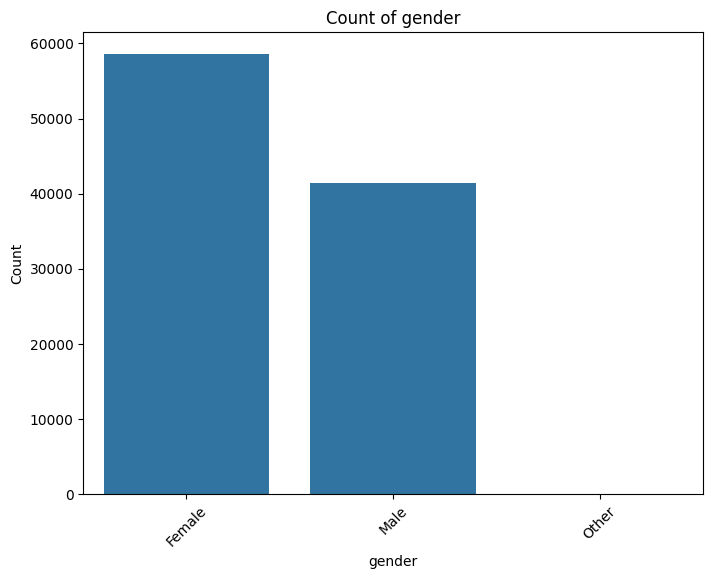

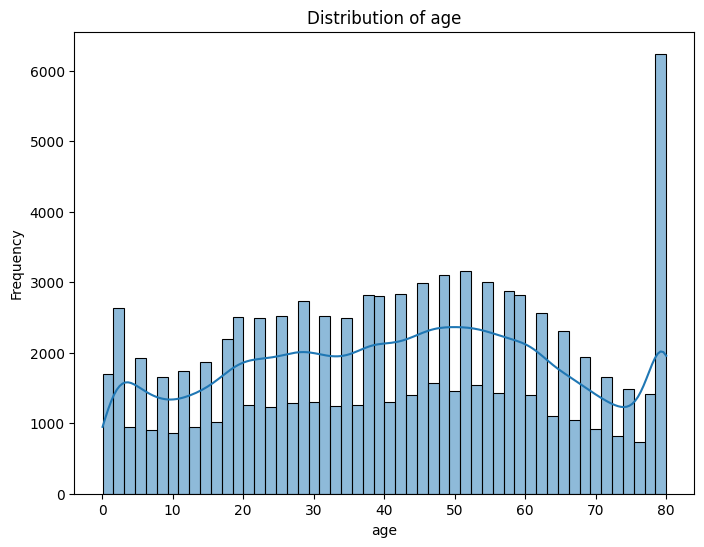

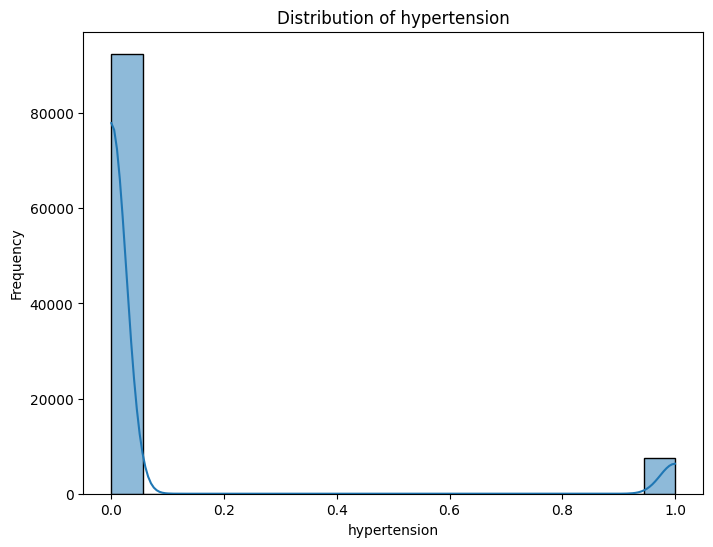

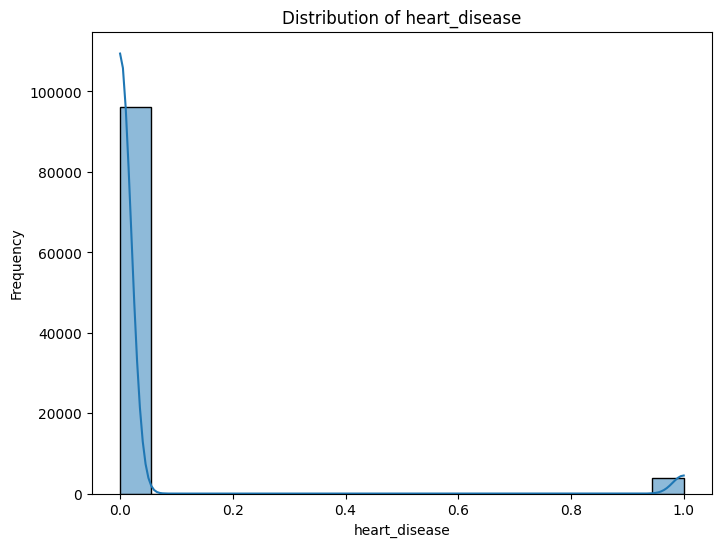

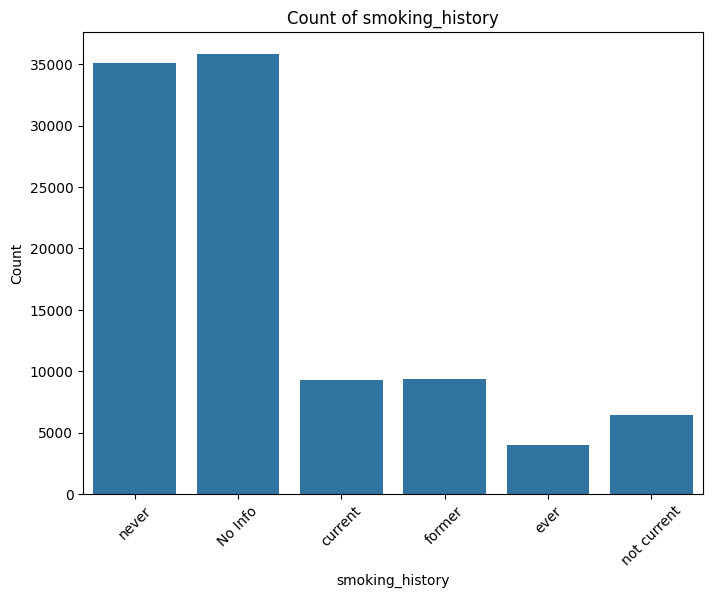

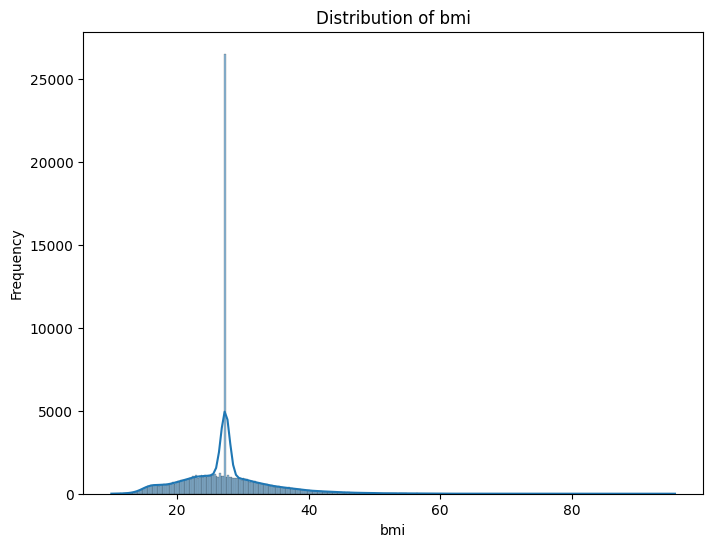

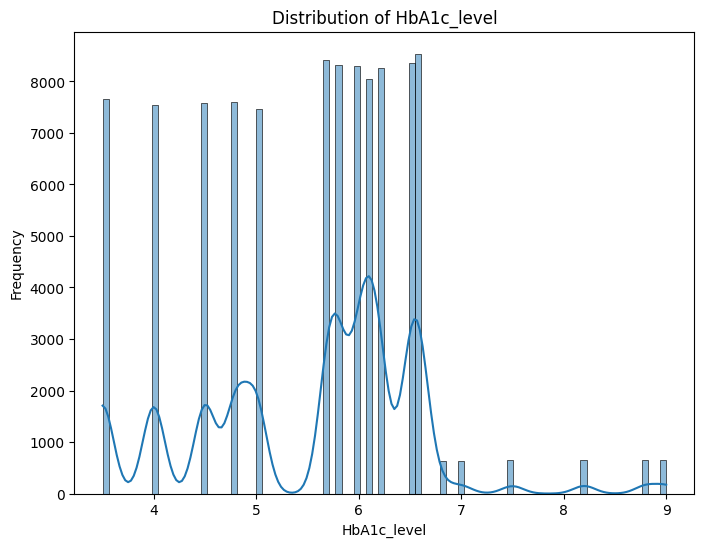

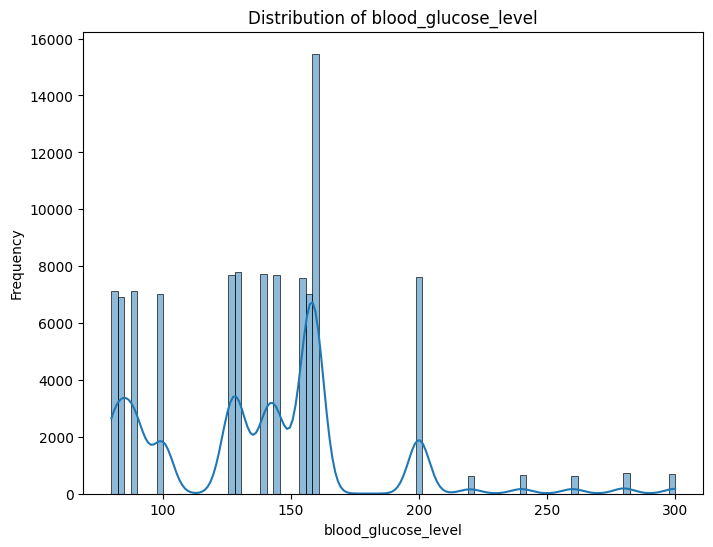

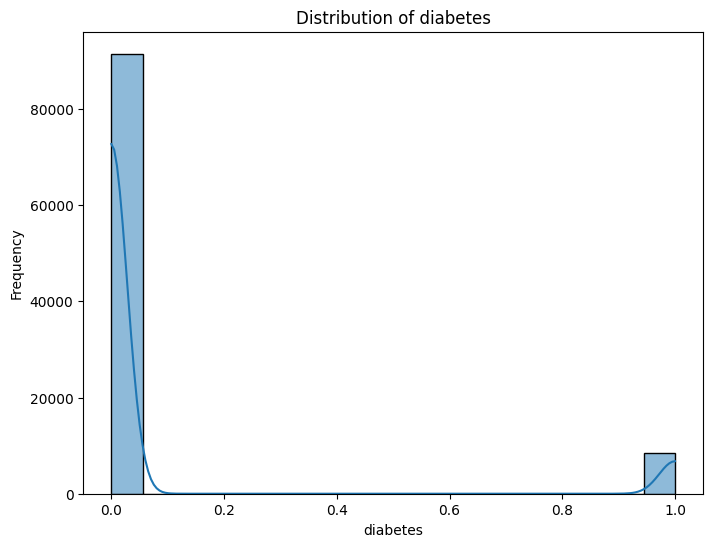

In [ ]:
for column in raw_diabetes_df.columns:
    if raw_diabetes_df[column].dtype in ['int64', 'float64']:
        # Plot histograms for numerical columns
        plt.figure(figsize=(8, 6))
        sns.histplot(data=raw_diabetes_df, x=column, kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()
    elif raw_diabetes_df[column].dtype == 'object':
        # Plot counts for categorical columns
        plt.figure(figsize=(8, 6))
        sns.countplot(data=raw_diabetes_df, x=column)
        plt.title(f'Count of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

## After the pre-data visualisation (just to see how the data are distributed)
#### We noticed for gender having (male, female, other), 3 categories,
#### For age, there are even an age of 0
#### Smoking history even up to 6 categories
#### For bmi have up to almost 100

therefore, we decided to further dive into their numeric and string values, to further understand.


In [ ]:
# Calculate the interquartile range (IQR) for 'bmi'
Q1 = raw_diabetes_df['bmi'].quantile(0.25)
Q3 = raw_diabetes_df['bmi'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = raw_diabetes_df[(raw_diabetes_df['bmi'] < lower_bound) | (raw_diabetes_df['bmi'] > upper_bound)]

# Count the number of outliers
num_outliers = len(outliers)

print("Number of outliers in 'bmi' column:", num_outliers)


Number of outliers in 'bmi' column: 7086


In [ ]:
# Access the 'bmi' values of the outliers DataFrame
outlier_values = outliers['bmi']

# Display the minimum and maximum values of the outliers
min_outlier_value = outlier_values.min()
max_outlier_value = outlier_values.max()

print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

print("Minimum outlier value in 'bmi' column:", min_outlier_value)
print("Maximum outlier value in 'bmi' column:", max_outlier_value)

# The minimum is still under acceptable range, therefore we accept it but not for the maximum range

Lower bound: 14.705
Upper bound: 38.504999999999995
Minimum outlier value in 'bmi' column: 10.01
Maximum outlier value in 'bmi' column: 95.69


In [ ]:
# Filter the DataFrame for records below the lower bound
below_lower_bound = raw_diabetes_df[raw_diabetes_df['bmi'] < lower_bound]

# Count the number of records below the lower bound
num_below_lower_bound = len(below_lower_bound)

print("Number of records below the lower bound in 'bmi' column (outliers):", num_below_lower_bound)
print(lower_bound)


Number of records below the lower bound in 'bmi' column (outliers): 1121
14.705


In [ ]:
### BMI got outliers
### HbA1c_level glucose(sugar) in your body that sticks to your red blood cells
### Body can't use the sugar properly, therefore it sticks to the red blood cells
### HbA1c (Hemoglobin A1c) level is a measure of a person's average blood sugar level over the past 2-3 months.
### 8.6 percent off HbA1c = red zone(danger zone), at high risk of developing diabetes.

### Blood glucose level immediate sugar level in the blood
### HbA1c average of blood glucose level in past 2 to 3 months, being measured for a period.
### HbA1c is a thorough test, instead of relying on just current blood sugar level, so we perform Hba1c, to see the overall conditions

In [ ]:
def get_unique_values(dataframe,col_list):
    for col in col_list:
        print('Column:',col)
        print('Unique values:',dataframe[col].unique())
        print('\n')

In [ ]:
get_unique_values(raw_diabetes_df,['gender','hypertension','heart_disease','smoking_history','diabetes'])

Column: gender
Unique values: ['Female' 'Male' 'Other']


Column: hypertension
Unique values: [0 1]


Column: heart_disease
Unique values: [1 0]


Column: smoking_history
Unique values: ['never' 'No Info' 'current' 'former' 'ever' 'not current']


Column: diabetes
Unique values: [0 1]




In [ ]:

# Assuming raw_diabetes_df is your dataframe containing the data
# Get unique values of smoking_history
unique_smoking_history = raw_diabetes_df['smoking_history'].unique()

# Iterate over unique values and count records associated with each value
for smoking_status in unique_smoking_history:
    count = raw_diabetes_df[raw_diabetes_df['smoking_history'] == smoking_status].shape[0]
    print(f"Number of records with smoking history '{smoking_status}': {count}")


Number of records with smoking history 'never': 35095
Number of records with smoking history 'No Info': 35816
Number of records with smoking history 'current': 9286
Number of records with smoking history 'former': 9352
Number of records with smoking history 'ever': 4004
Number of records with smoking history 'not current': 6447


# Data Preprocessing and Data Cleaning

## Data Cleaning

### Removal of any Duplicate rows (if any)

In [ ]:
raw_diabetes_df.duplicated().sum()

3854

In [ ]:
raw_diabetes_df.drop_duplicates(inplace=True)

In [ ]:
raw_diabetes_df.duplicated().sum()

0

In [ ]:
raw_diabetes_df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [ ]:
raw_diabetes_df.describe(include='object')

,gender,smoking_history
count,96146,96146
unique,3,6
top,Female,never
freq,56161,34398


In [ ]:
raw_diabetes_df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
std,22.462948,0.267544,0.197833,6.767716,1.073232,40.909771,0.283616
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


### Filter age that below 5 years old

In [ ]:
# Round the age values to integers
raw_diabetes_df['age'] = raw_diabetes_df['age'].round().astype(int)

# Filter out rows where age is less than 5
raw_diabetes_df = raw_diabetes_df[raw_diabetes_df['age'] >= 5]


In [ ]:
raw_diabetes_df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,90973.000000,90973.000000,90973.000000,90973.000000,90973.000000,90973.000000,90973.000000
mean,44.047794,0.082002,0.043112,27.823505,5.539448,138.558309,0.093160
std,20.947931,0.274370,0.203110,6.534208,1.078410,41.225670,0.290657
min,5.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,27.000000,0.000000,0.000000,24.140000,4.800000,100.000000,0.000000
50%,45.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.000000,0.000000,30.210000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
###Selecting an age threshold of 5 ensures our analysis focuses on individuals beyond early childhood,
###where diabetes onset is rare.
###By targeting this demographic, we obtain more accurate insights for guiding interventions
###to manage the condition effectively.

### Convert gender into numerical

In [ ]:
# Number of gender that is "Other"
num_other_gender = (raw_diabetes_df['gender'] == 'Other').sum()
num_other_gender

18

In [ ]:
# [Data thrown = 18]
total_rows = len(raw_diabetes_df)

percentage_other_gender = (num_other_gender / total_rows) * 100
print("Data loss peercentage: ", percentage_other_gender, "%")

Data loss peercentage:  0.01978609037846394 %


In [ ]:
# Drop gender "Other"
# Contrast when turn into numerical value
raw_diabetes_df = raw_diabetes_df[raw_diabetes_df['gender'] != 'Other']

In [ ]:
# Convert gender values to 0 for male and 1 for female
raw_diabetes_df['gender'] = raw_diabetes_df['gender'].apply(lambda x: 1 if x.lower() == 'female' else 0)


print(raw_diabetes_df['gender'])

0        1
1        1
2        0
3        1
4        0
        ..
99993    1
99994    1
99997    0
99998    1
99999    1
Name: gender, Length: 90955, dtype: int64


In [ ]:
raw_diabetes_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,80,0,1,never,25.19,6.6,140,0
1,1,54,0,0,No Info,27.32,6.6,80,0
2,0,28,0,0,never,27.32,5.7,158,0
3,1,36,0,0,current,23.45,5.0,155,0
4,0,76,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99993,1,40,0,0,never,40.69,3.5,155,0
99994,1,36,0,0,No Info,24.60,4.8,145,0
99997,0,66,0,0,former,27.83,5.7,155,0
99998,1,24,0,0,never,35.42,4.0,100,0


### Outlier Handling for the 'bmi' Column

In [ ]:

# Replace BMI values greater than 70 with 70
raw_diabetes_df.loc[raw_diabetes_df['bmi'] > 70, 'bmi'] = 70

# Display the DataFrame
raw_diabetes_df['bmi'].describe()


count    90955.000000
mean        27.821269
std          6.516151
min         10.010000
25%         24.140000
50%         27.320000
75%         30.210000
max         70.000000
Name: bmi, dtype: float64

In [ ]:
### In Malaysia, BMI values above 70 are incredibly rare.
### By setting a cap at 70, we're keeping our health assessments grounded in the reality of
### our community's health. This approach helps us focus on what's most common and relevant,
### making sure we're accurately assessing health and offering the right support where it's needed most.

## Then deal with smoke history column
Since value of "No Info" makes no sense, therefore we decided to drop it.
Then, to make the data simpler and clearer, we decided to categorized it as smoker and non-smoker. We treat all the categories like "current, former, ever, not current" as smokers, and only never as non-smoker.

In [ ]:
# Step 1: Drop records with 'No Info' smoking history
raw_diabetes_df = raw_diabetes_df[raw_diabetes_df['smoking_history'] != 'No Info']

# Step 2: Categorize smokers and non-smokers
raw_diabetes_df['smoking_status'] = raw_diabetes_df['smoking_history'].apply(lambda x: 0 if x == 'never' else 1)

# Display the updated dataframe
print(raw_diabetes_df.head())

   gender  age  hypertension  heart_disease smoking_history    bmi  \
0       1   80             0              1           never  25.19   
2       0   28             0              0           never  27.32   
3       1   36             0              0         current  23.45   
4       0   76             1              1         current  20.14   
5       1   20             0              0           never  27.32   

   HbA1c_level  blood_glucose_level  diabetes  smoking_status  
0          6.6                  140         0               0  
2          5.7                  158         0               0  
3          5.0                  155         0               1  
4          4.8                  155         0               1  
5          6.6                   85         0               0  


## Data Preprocessing

### Scaling Numeric Features using Min-Max Scaling
 Features with larger scales may dominate the learning process of many machine learning algorithms. Scaling ensures that all features contribute equally to the model, preventing features with larger scales from having a disproportionate influence on the outcome.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale 'bmi' column
raw_diabetes_df['scaled_bmi'] = scaler.fit_transform(raw_diabetes_df['bmi'].values.reshape(-1, 1)).flatten()

# Scale 'age' column
raw_diabetes_df['scaled_age'] = scaler.fit_transform(raw_diabetes_df['age'].values.reshape(-1, 1)).flatten()

# Drop original columns if needed
raw_diabetes_df.drop(columns=['bmi', 'age'], inplace=True)

# Display the resulting DataFrame
raw_diabetes_df

,gender,hypertension,heart_disease,smoking_history,HbA1c_level,blood_glucose_level,diabetes,smoking_status,scaled_bmi,scaled_age
0,1,0,1,never,6.6,140,0,0,0.252170,1.000000
2,0,0,0,never,5.7,158,0,0,0.287717,0.306667
3,1,0,0,current,5.0,155,0,1,0.223131,0.413333
4,0,1,1,current,4.8,155,0,1,0.167891,0.946667
5,1,0,0,never,6.6,85,0,0,0.287717,0.200000
...,...,...,...,...,...,...,...,...,...,...
99992,1,0,0,never,6.5,160,0,0,0.404873,0.280000
99993,1,0,0,never,3.5,155,0,0,0.510848,0.466667
99997,0,0,0,former,5.7,155,0,1,0.296228,0.813333
99998,1,0,0,never,4.0,100,0,0,0.422897,0.253333


In [ ]:
# Define columns to be scaled
columns_to_scale = ['HbA1c_level', 'blood_glucose_level']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale the selected columns and create new columns with scaled values
for column in columns_to_scale:
    # Create new column name
    new_column_name = f"scaled_{column}"
    # Scale the column and assign to the new column
    raw_diabetes_df[new_column_name] = scaler.fit_transform(raw_diabetes_df[[column]])

# Display the updated dataframe with scaled columns
print(raw_diabetes_df)

       gender  hypertension  heart_disease smoking_history  HbA1c_level  \
0           1             0              1           never          6.6   
2           0             0              0           never          5.7   
3           1             0              0         current          5.0   
4           0             1              1         current          4.8   
5           1             0              0           never          6.6   
...       ...           ...            ...             ...          ...   
99992       1             0              0           never          6.5   
99993       1             0              0           never          3.5   
99997       0             0              0          former          5.7   
99998       1             0              0           never          4.0   
99999       1             0              0         current          6.6   

       blood_glucose_level  diabetes  smoking_status  scaled_bmi  scaled_age  \
0                  

In [ ]:
# List of columns to include in the filtered dataframe
columns_to_include = ['gender', 'hypertension', 'heart_disease', 'diabetes', 'smoking_status', 'scaled_bmi', 'scaled_age', 'scaled_HbA1c_level', 'scaled_blood_glucose_level']

# Initialize an empty dataframe
filtered_diabetes_df = pd.DataFrame()

# Iterate over each column to determine whether to use scaled or original version
for column in columns_to_include:
    # Check if a scaled version of the column exists
    if f"scaled_{column}" in raw_diabetes_df.columns:
        # Use the scaled version if available
        filtered_diabetes_df[column] = raw_diabetes_df[f"scaled_{column}"]
    else:
        # Use the original version if scaled version does not exist
        filtered_diabetes_df[column] = raw_diabetes_df[column]

# Display the filtered dataframe
print(filtered_diabetes_df)


       gender  hypertension  heart_disease  diabetes  smoking_status  \
0           1             0              1         0               0   
2           0             0              0         0               0   
3           1             0              0         0               1   
4           0             1              1         0               1   
5           1             0              0         0               0   
...       ...           ...            ...       ...             ...   
99992       1             0              0         0               0   
99993       1             0              0         0               0   
99997       0             0              0         0               1   
99998       1             0              0         0               0   
99999       1             0              0         0               1   

       scaled_bmi  scaled_age  scaled_HbA1c_level  scaled_blood_glucose_level  
0        0.252170    1.000000            0.563636      

## Data Analysis
#### Analysis and visualization after preprocessing

In [ ]:
filtered_diabetes_df.describe().round(2)

,gender,hypertension,heart_disease,diabetes,smoking_status,scaled_bmi,scaled_age,scaled_HbA1c_level,scaled_blood_glucose_level
count,62627.00,62627.0,62627.00,62627.00,62627.00,62627.00,62627.00,62627.00,62627.00
mean,0.61,0.1,0.05,0.11,0.46,0.31,0.56,0.38,0.27
std,0.49,0.3,0.21,0.32,0.50,0.11,0.26,0.20,0.19
min,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.0,0.00,0.00,0.00,0.24,0.35,0.24,0.09
50%,1.00,0.0,0.00,0.00,0.00,0.29,0.56,0.42,0.27
75%,1.00,0.0,0.00,0.00,1.00,0.35,0.76,0.49,0.36
max,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00


#### Histogram for scaled age

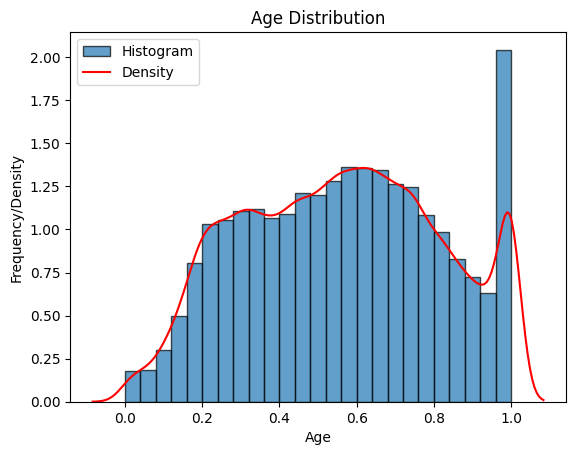

In [ ]:
plt.hist(filtered_diabetes_df['scaled_age'], bins=25, edgecolor='black', alpha=0.7, label='Histogram', density=True)
sns.kdeplot(filtered_diabetes_df['scaled_age'], color='red', label='Density')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency/Density')
plt.legend()
plt.show()

#### Distribution plot for BMI, HbA1c level and blood glucose level

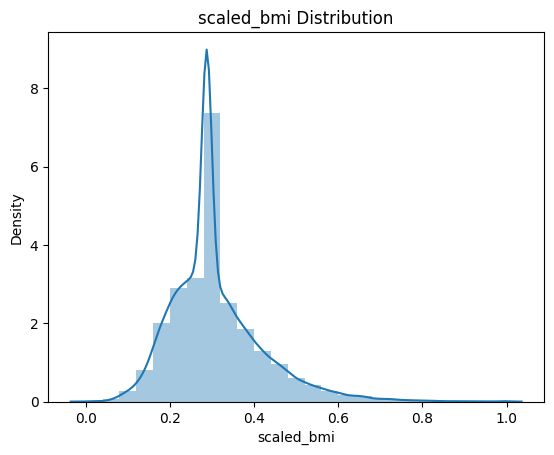

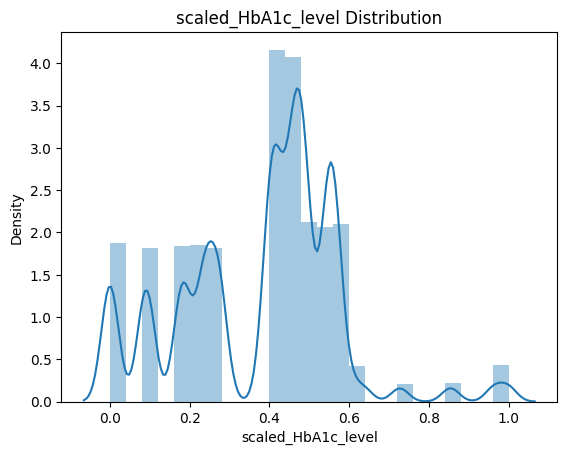

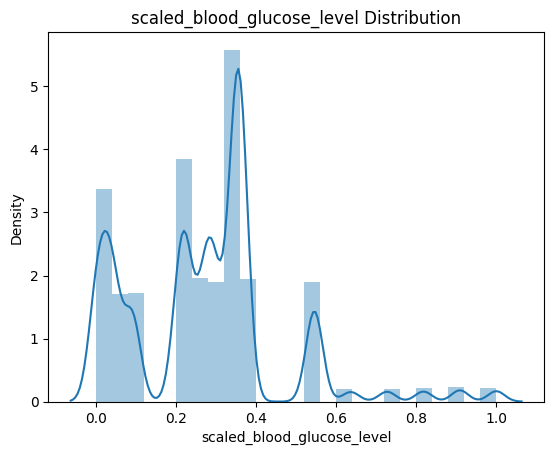

In [ ]:
for col in ['scaled_bmi', 'scaled_HbA1c_level','scaled_blood_glucose_level']:
    sns.distplot(filtered_diabetes_df[col], bins=25)
    plt.title(f'{col} Distribution')
    plt.xlabel(f'{col}')
    plt.show()

#### Counting binary variables

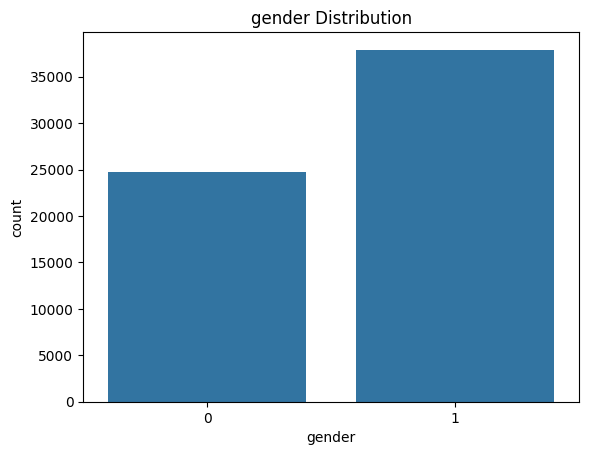

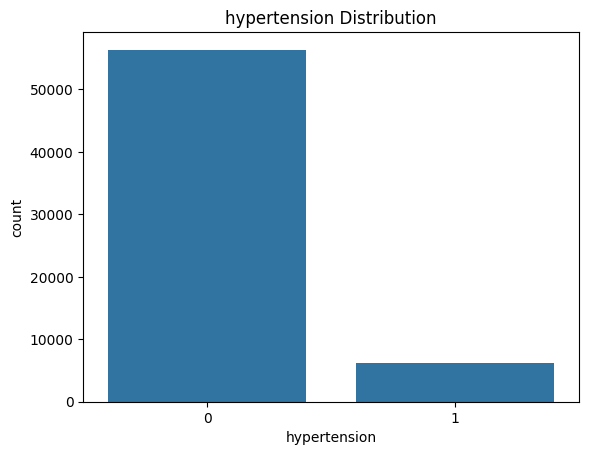

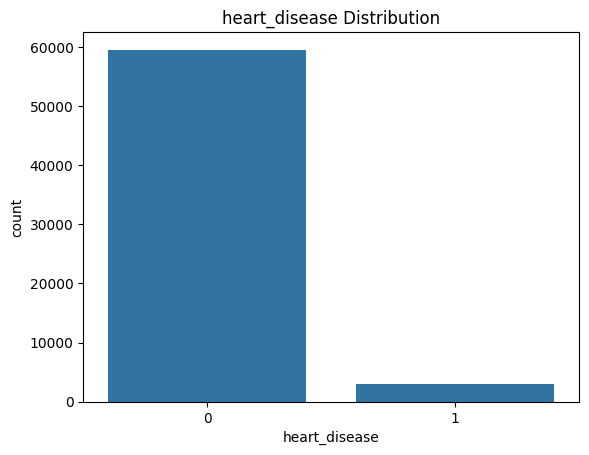

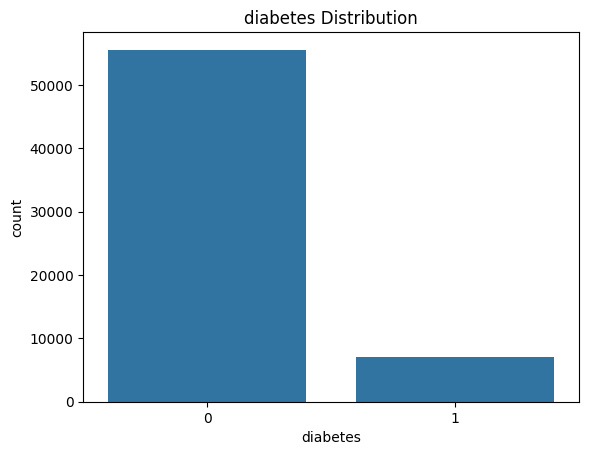

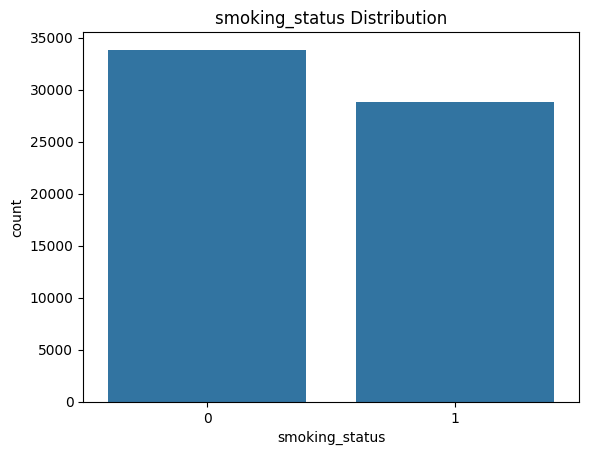

In [ ]:
for col in ['gender', 'hypertension', 'heart_disease', 'diabetes', 'smoking_status']:
    sns.countplot(x=col, data=filtered_diabetes_df)
    plt.title(f'{col} Distribution')
    plt.show()
# Gender: 0=Male, 1=Female

#### Pair plot for numeric features

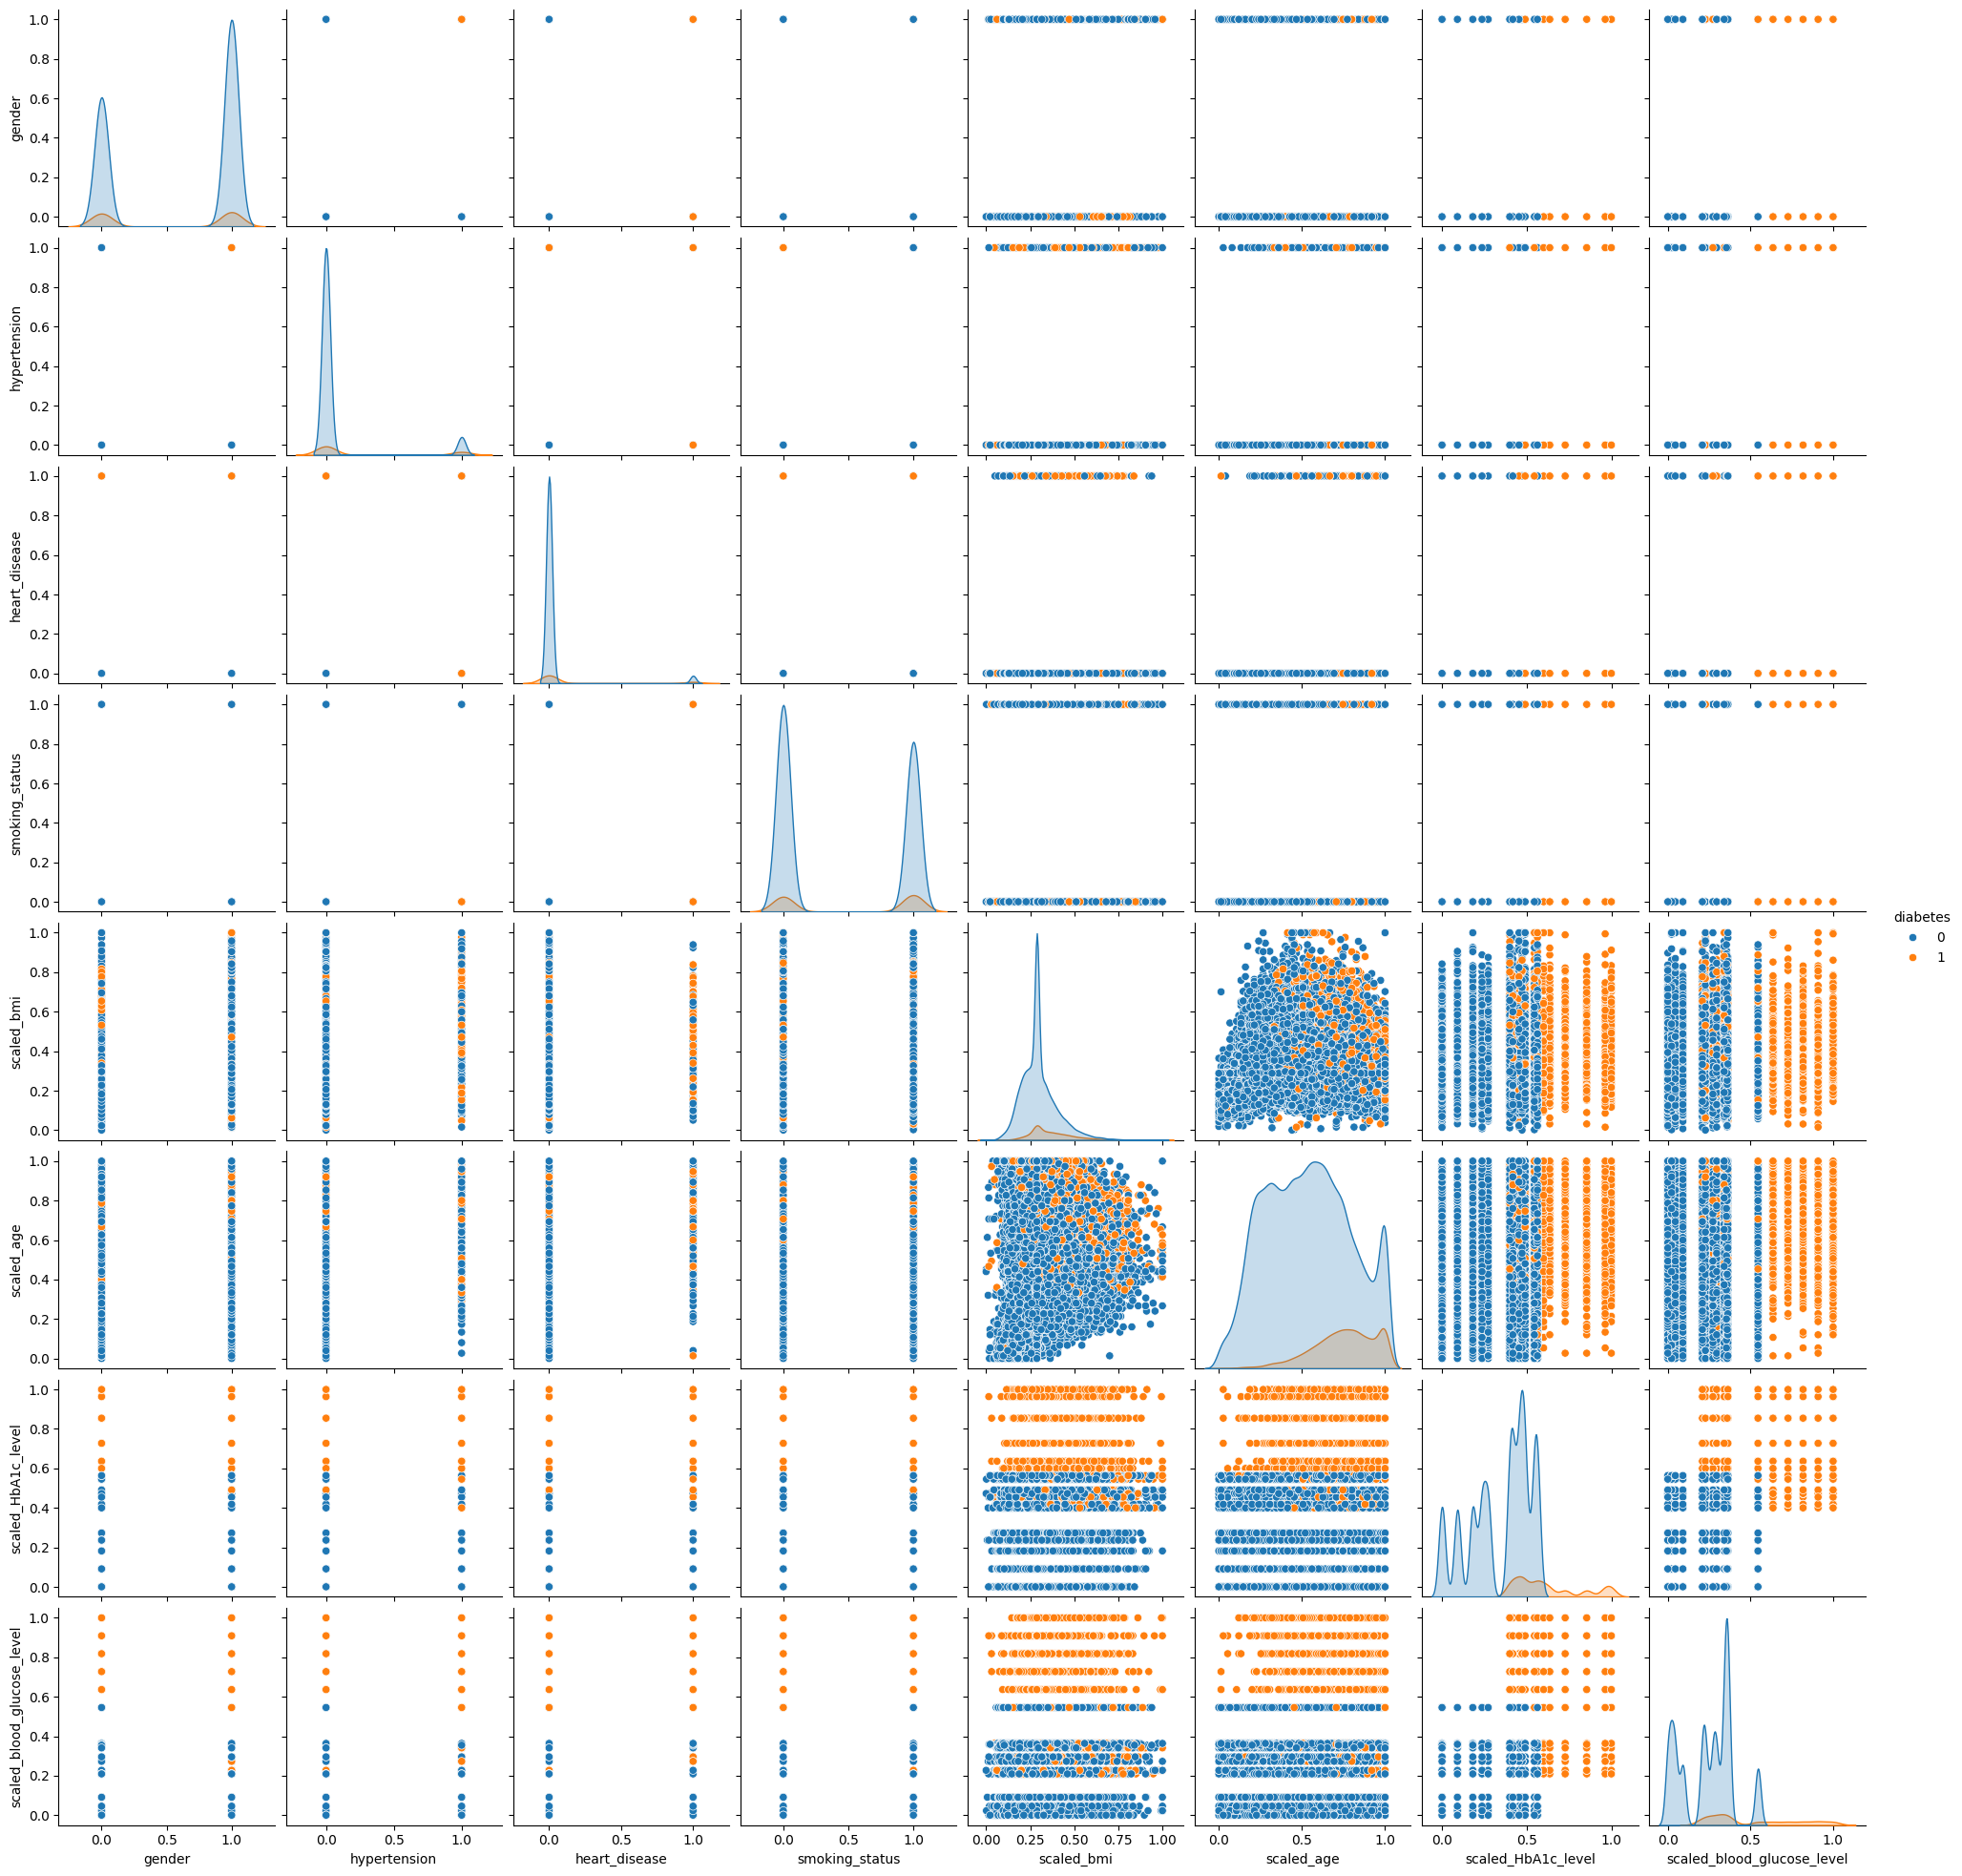

In [ ]:
sns.pairplot(filtered_diabetes_df, hue='diabetes')
plt.show()

#### Countplot of gender, hypertension, heart disease, smoking status vs diabetes

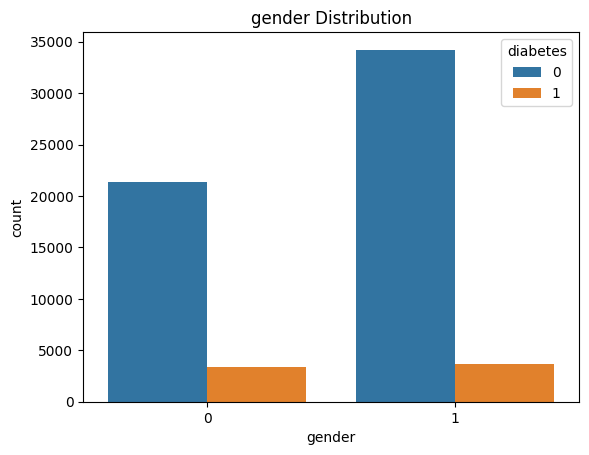

Rates of diabetes occurrence for different gender categories:
gender
0    13.50
1     9.75
Name: diabetes, dtype: object


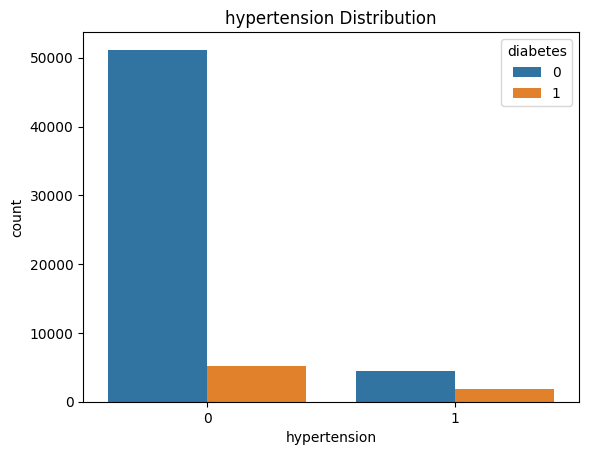

Rates of diabetes occurrence for different hypertension categories:
hypertension
0     9.22
1    29.28
Name: diabetes, dtype: object


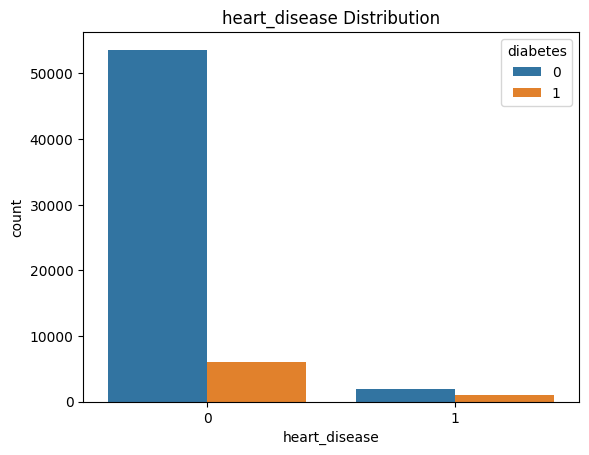

Rates of diabetes occurrence for different heart_disease categories:
heart_disease
0    10.03
1    34.88
Name: diabetes, dtype: object


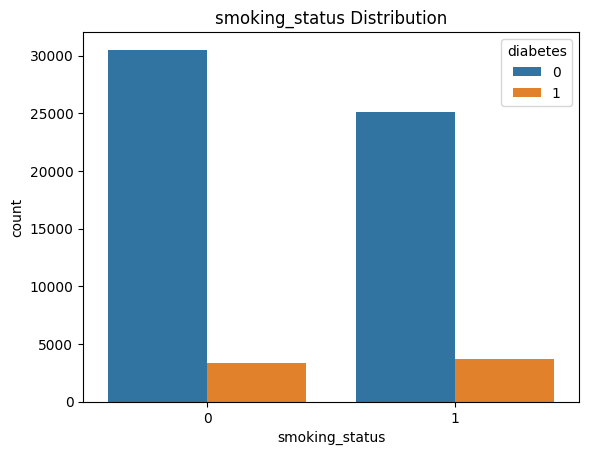

Rates of diabetes occurrence for different smoking_status categories:
smoking_status
0     9.85
1    12.86
Name: diabetes, dtype: object


In [ ]:
for col in ['gender', 'hypertension', 'heart_disease', 'smoking_status']:
    sns.countplot(x=col, data=filtered_diabetes_df, hue='diabetes')
    plt.title(f'{col} Distribution')
    plt.show()

    rates = filtered_diabetes_df.groupby(col)['diabetes'].mean() * 100
    formatted_rates = rates.apply(lambda x: "{:.2f}".format(x))
    print(f"Rates of diabetes occurrence for different {col} categories:")
    print(formatted_rates)

# Gender: 0 = male, 1 = female

#### Analysis between catagorical variables with diabetes
##### Gender vs Diabetes: Both gender have almost the same rate of having diabetes.
##### Hypertension vs Diabetes: Patients with hypertension has a higher rate (20% more compare to patients without hypothesis) of having diabetes.
##### Heart Disease vs Diabetes: Patients with heart disease has a higher rate (25% more compare to patients without hypothesis) of having diabetes.
##### Smoking Status vs Diabetes: Both status are having almost similar rate of having hypothesis, but there is a slight difference.
##### In short, patients with hypertension and heart disease are more likely to develop diabetes than those without.

#### Boxplot of bmi, age, HbA1c level, blood glucose level vs diabetes classification

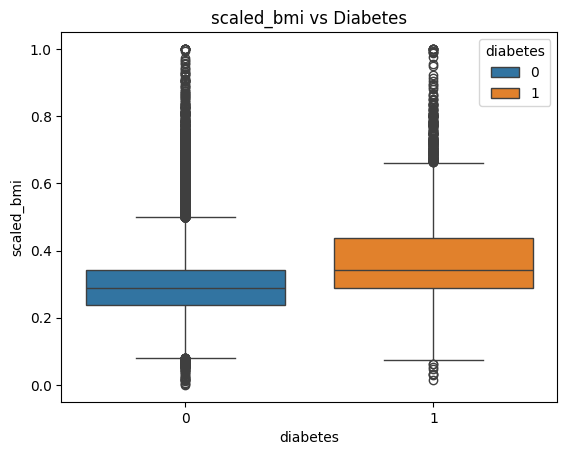

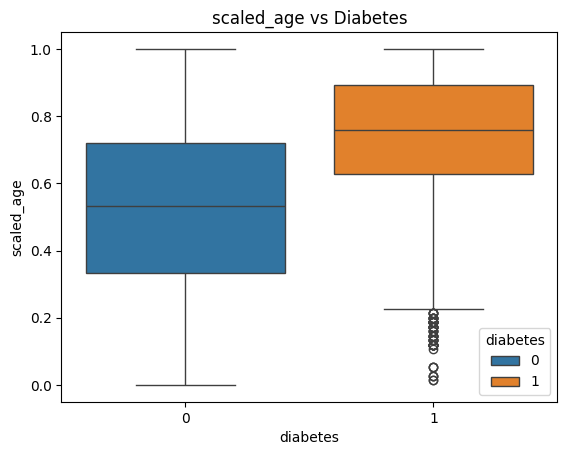

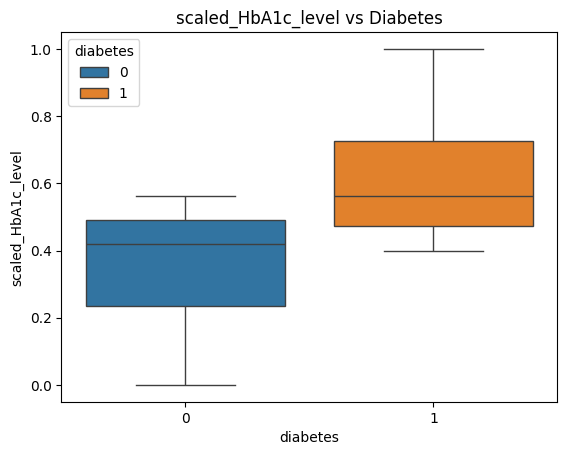

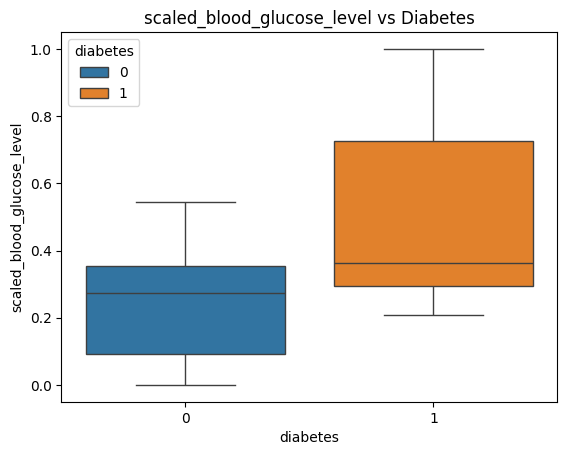

In [ ]:
for col in ['scaled_bmi', 'scaled_age', 'scaled_HbA1c_level', 'scaled_blood_glucose_level']:
    sns.boxplot(x='diabetes', y=col, data=filtered_diabetes_df, hue='diabetes')
    plt.title(f'{col} vs Diabetes')
    plt.show()

#### Analysis between continuous variables with diabetes
##### Scaled BMI vs Diabetes: Boxplot shows that the scaled BMI contains outlier for both diabetes patients and non-diabetes patients. Most of the non-diabetes patients have the scaled BMI lied between 0.2-0.4 where most of the diabetes patients have the scaled BMI lied between 0.3-0.5. According to boxplot, diabetes patients have a larger distribution of scaled BMI. However, the variable are less effective since it does not affect the results much but still taken into consideration.
##### Scaled Age vs Diabetes: Boxplot shows that the scaled age for diabetes patients contain outlier. Most of the non-diabetes patients have the scaled age lied between 0.3-0.7, while most of the diabetes patients have the scaled age lied between 0.6-0.9, indicates that most of the diabetes patients are from higher ages. The variable is effective.
##### Scaled HbA1c Level vs Diabetes: Boxplot shows that there is no outlier in scaled HbA1c level. Most of the non-diabetes patients have the scaled HbA1c level lied between 0.2-0.5, while most of the diabetes patients have the scaled HbA1c level lied between 0.4-0.8, indicates that most of the diabetes patients have higher HbA1c level. The variable is effective.
##### Scaled Blood Glucose Level vs Diabetes: Boxplot shows that there is no outlier in scaled blood glucose level. Most of the non-diabetes patients have the scaled blood glucose level lied between 0-0.4, while most of the diabetes patients have the scaled blood glucose level lied between 0.3-0.8, indicates that most of the diabetes patients have higher blood glucose level. The variable is effective.

#### Scatterplot Age vs BMI colored by diabetes classification
##### Compare 2 continuous variables with diabetes

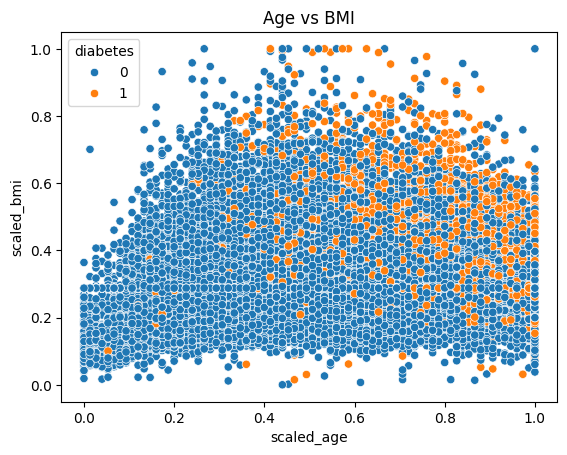

In [ ]:
sns.scatterplot(x='scaled_age', y='scaled_bmi', hue='diabetes', data=filtered_diabetes_df)
plt.title('Age vs BMI')
plt.show()

##### Orange colour indicates diabetes patients whereas blue colour indicates non-diabetes patients.
##### Most of the diabetes patients distributed at a higher scaled age
##### However, there is not much different of distribution of diabetes patients between high scaled bmi and low scaled BMI (almost equally distributed), indicates that there affect between diabetes on BMI are less obvious
##### In short, diabetes patients are mostly affected by age than BMI

#### Violin plot of BMI against diabetes classification split by gender

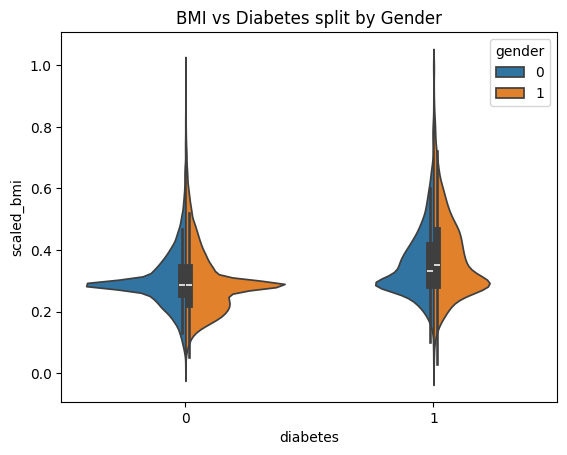

In [ ]:
# Gender: 0=Male, 1=Female
sns.violinplot(x='diabetes', y='scaled_bmi', hue='gender', split=True, data=filtered_diabetes_df)
plt.title('BMI vs Diabetes split by Gender')
plt.show()

##### Kernel Density Estimation (KDE) plot shows the probability density function of the data.
##### For male non-diabetes patients, the scaled BMI is symmetrically distributed around its median; while for female non-diabetes, the scaled BMI is also almost symmetrically distributed around its median. Both gender of non-diabetes patients have the same median of scaled BMI which is approximately 0.3.
##### For diabetes patients, the median of scaled BMI for both gender approximately lies between 0.3-0.4 which is slightly higher than non-diabetes patients. However, female patients have a slightly higher median of scaled BMI compared to male patients. Both gender are asymmetrically distributed around their median, which are positive skewness (Right-skewed).
##### From the violinplot above, we can conclude that factor of gender do not affect on the rate of having diabetes while BMI slightly affect the rate.

#### Interation between variables and diabetes

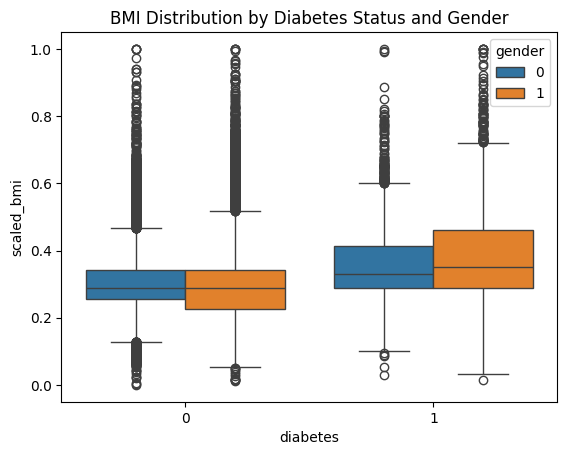

In [ ]:
# Interaction between gender, BMI and diabetes
sns.boxplot(x='diabetes', y='scaled_bmi', hue='gender', data=filtered_diabetes_df)
plt.title('BMI Distribution by Diabetes Status and Gender')
plt.show()

BMI are slightly higher for diabetes patients but gender does not show much effect.

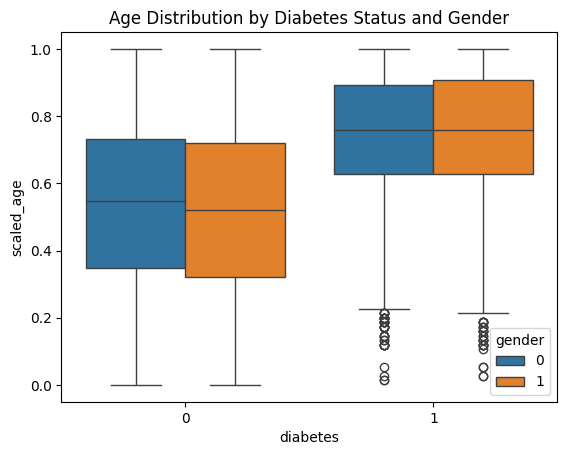

In [ ]:
# Interaction between gender, Age and diabetes
sns.boxplot(x='diabetes', y='scaled_age', hue='gender', data=filtered_diabetes_df)
plt.title('Age Distribution by Diabetes Status and Gender')
plt.show()

Age shows obvious effect on the rate of having diabetes, that is higher age have a higher chance of having diabetes.

### Enocoding
 One-hot encoding is performed to prepare categorical variables for inclusion in models, ensuring the models can effectively utilize all available information without introducing biases or misinterpretations.
 One-hot encoding is performed on the 'gender' and 'smoking_status' variables in the diabetes dataset

In [ ]:
data = filtered_diabetes_df.copy()

def perform_one_hot_encoding(filtered_diabetes_df, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(filtered_diabetes_df[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    filtered_diabetes_df = pd.concat([filtered_diabetes_df.drop(column_name, axis=1), dummies], axis=1)

    return filtered_diabetes_df

# Perform one-hot encoding on the gender variable
data = perform_one_hot_encoding(data, 'gender')

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_status')

### Correlation Matrix
##### To show and compare the relationship berwwen all variables.

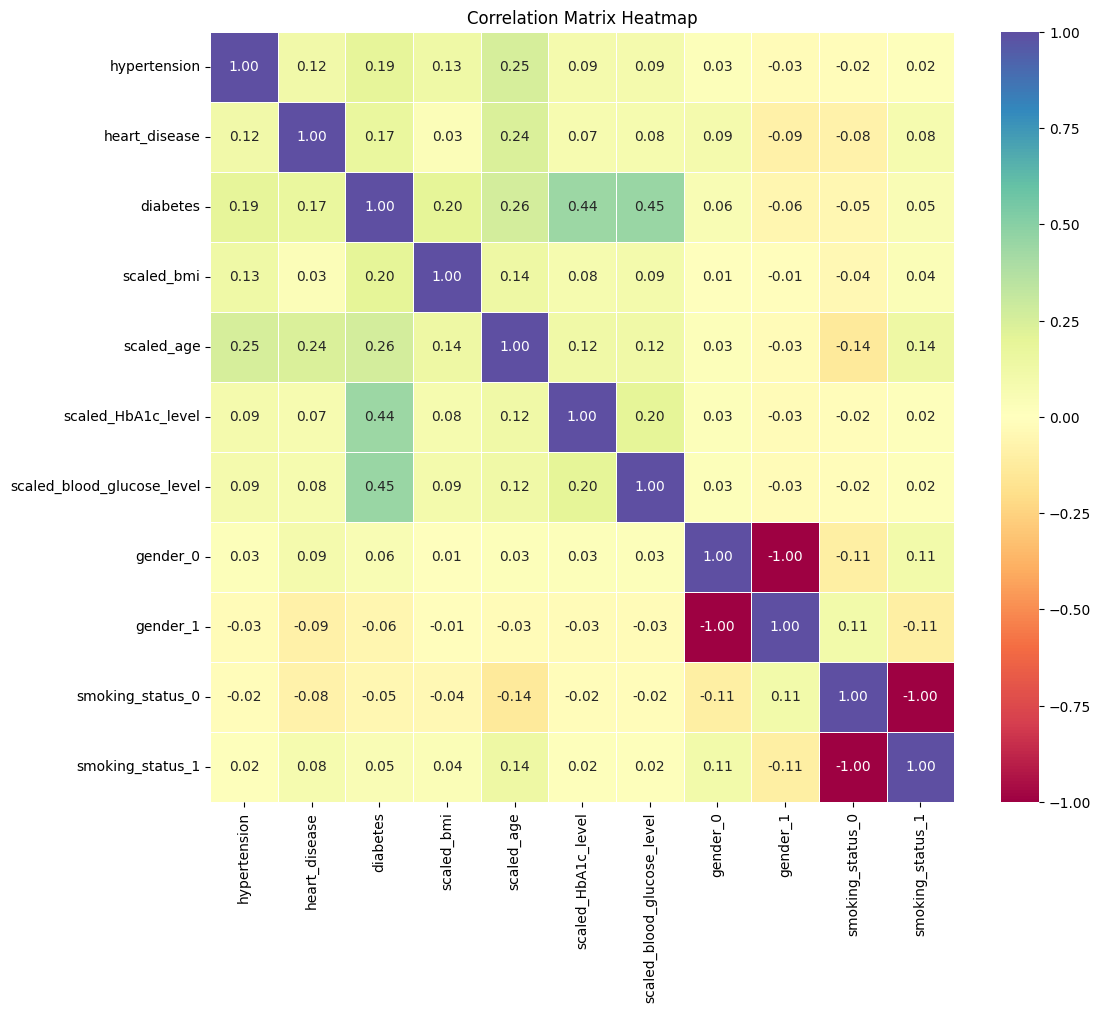

In [ ]:
# Compute the correlation matrix
correlation_matrix = data.corr()
# HeatMap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Spectral', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

HeatMap is targeted to the variables that compare with the diabetes to show their relationship.

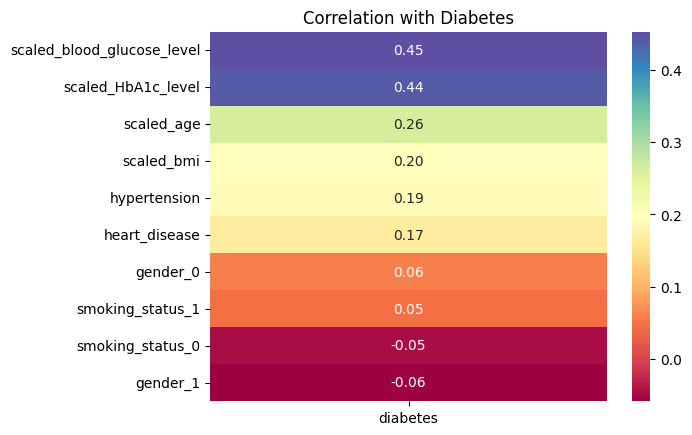

In [ ]:
# Targeted heatmap
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.heatmap(target_corr_sorted.to_frame(), cmap="Spectral", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

As the HeatMap shown, the effect of variables on diabetes are list accordingly from the most important to less important.
In the other way, we can conclude that the most important variables are the most reliable factors to consider as the diabetes prediction.
The most important factors to determine a diabetes patient is blood glucose level, HbA1c level, followed by age, BMI, hypertension and heart disease.
Gender and smoking status are not taken into consideration as the factor does not show effect on the factor to determine a diabetes patient.

### Handling class imbalance

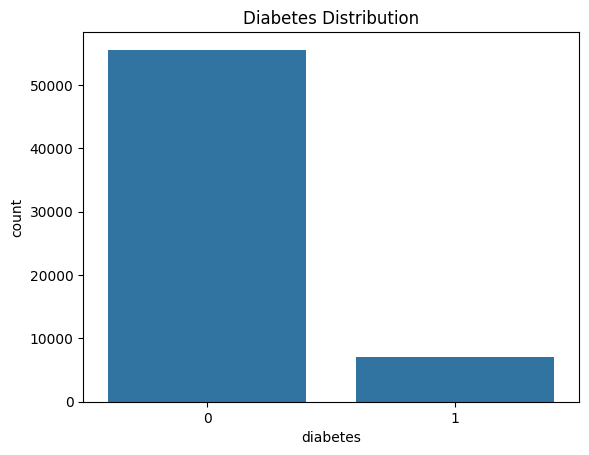

Percentage of positive cases of diabetes: 11.23 %


In [ ]:
# Count plot for the 'diabetes' variable
sns.countplot(x='diabetes', data=filtered_diabetes_df)
plt.title('Diabetes Distribution')
plt.show()

# Calculate percentage of positive cases of diabetes
total_cases = len(filtered_diabetes_df)
positive_cases = filtered_diabetes_df['diabetes'].sum()
percentage_positive_cases = (positive_cases / total_cases) * 100
formatted_percentage = "{:.2f}".format(percentage_positive_cases)
print("Percentage of positive cases of diabetes:", formatted_percentage, "%")

After sorting the dataset, only 62627 rows of data accepted and proceed to data modelling

# Data Modelling

 ## Split the dataset into training, validation, and test sets

### Check the class distribution

In [ ]:
class_distribution = filtered_diabetes_df['diabetes'].value_counts()
print("Class Distribution:")
print(class_distribution)


Class Distribution:
diabetes
0    55594
1     7033
Name: count, dtype: int64


### Split Original Dataset

In [ ]:
# Split the original dataset
X = filtered_diabetes_df.drop('diabetes', axis=1).values
y = filtered_diabetes_df['diabetes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print('               x       y ')
print('Original set:', X.shape, y.shape)
print('Training set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

               x       y 
Original set: (62627, 8) (62627,)
Training set: (43838, 8) (43838,)
Test set: (18789, 8) (18789,)


## Model Selection



###Resampling using SMOTE

In [ ]:
# Define the resampling techniques
over = SMOTE(sampling_strategy=0.25)  # Increase the sampling strategy for over-sampling

# Apply resampling to the training data
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)

y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['diabetes'])

# Check the class distribution
class_distribution = y_train_resampled_df['diabetes'].value_counts()
print("Class Distribution after Resampling:")
print(class_distribution)


Class Distribution after Resampling:
diabetes
0    38969
1     9742
Name: count, dtype: int64


###Model Training and Evaluation


Logistic Regression Metrics:
Accuracy: 0.9404970993666507
Precision: 0.7551219512195122
Recall: 0.7153419593345656
ROC score: 0.8425732353063804
F1 Score: 0.7346938775510203


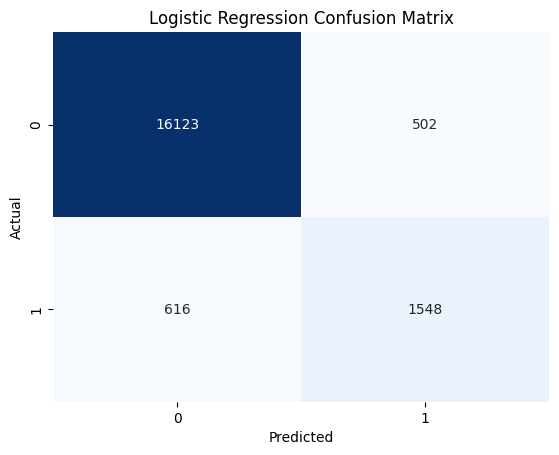

Random Forest Metrics:
Accuracy: 0.957155782638778
Precision: 0.8934568616097278
Recall: 0.7130314232902033
ROC score: 0.8509818770586355
F1 Score: 0.793112310460036


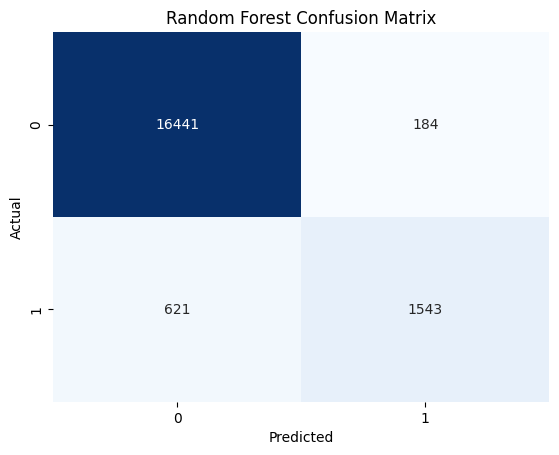

Decision Tree Metrics:
Accuracy: 0.9315024748523072
Precision: 0.6833960685905479
Recall: 0.755083179297597
ROC score: 0.8547746723555655
F1 Score: 0.7174533479692645


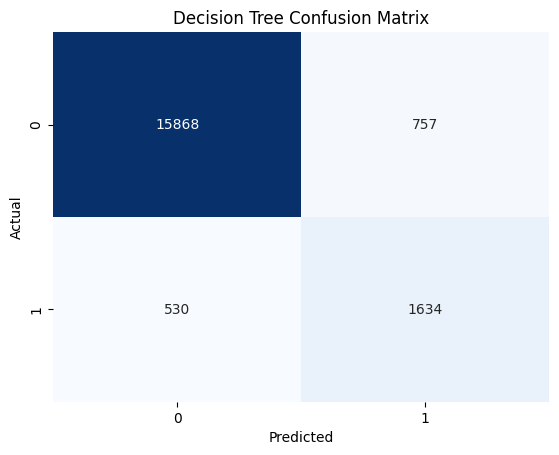

KNeighbors Classifier Metrics:
Accuracy: 0.9375698547022194
Precision: 0.7297171998145573
Recall: 0.7273567467652495
ROC score: 0.8461445387961586
F1 Score: 0.7285350613283962


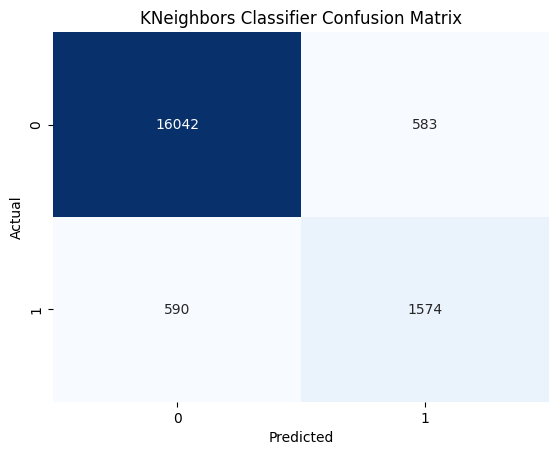

Support Vector Machine Metrics:
Accuracy: 0.948374048645484
Precision: 0.8466898954703833
Recall: 0.6737523105360443
ROC score: 0.828936305643962
F1 Score: 0.7503860010293361


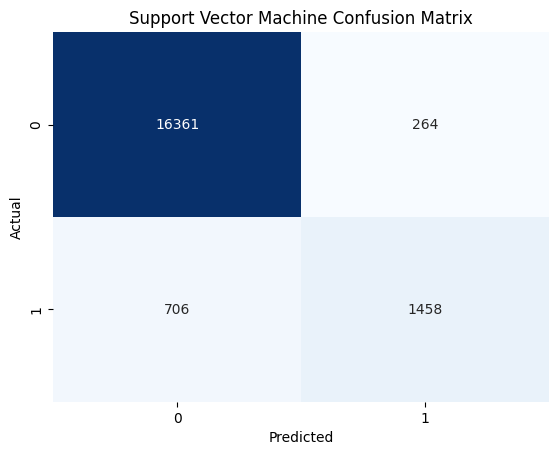

Best Model: RandomForestClassifier()
Best F1 Score on Test Set: 0.793112310460036


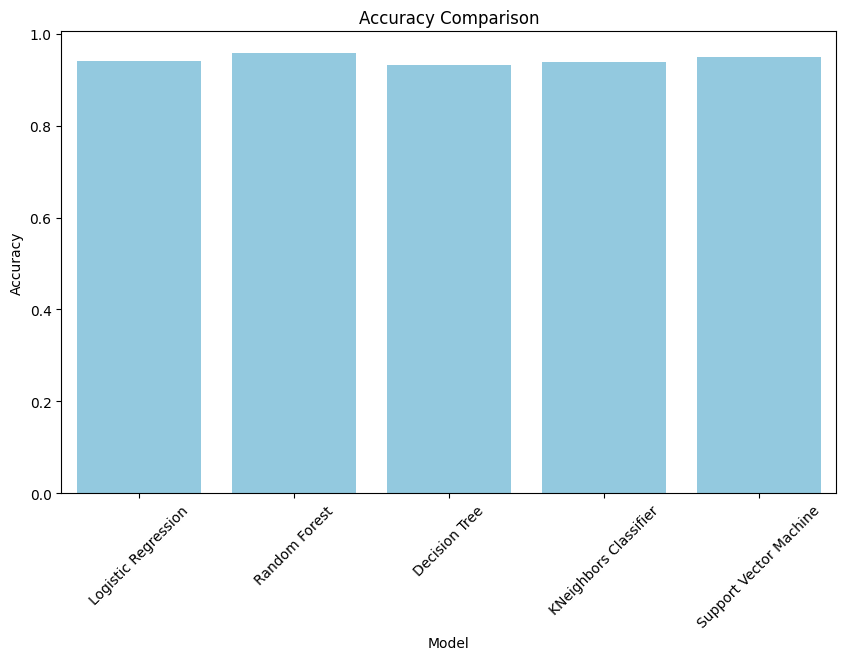

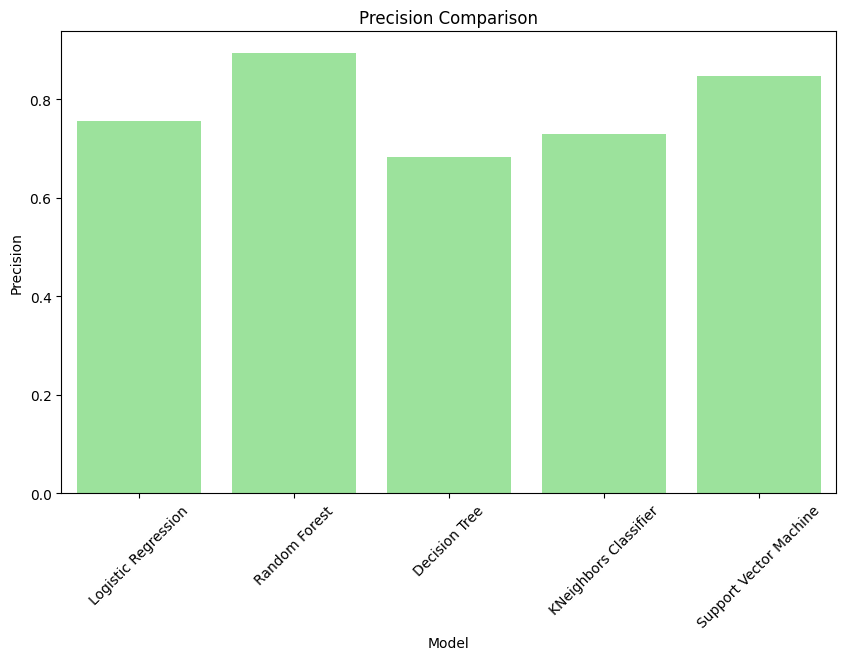

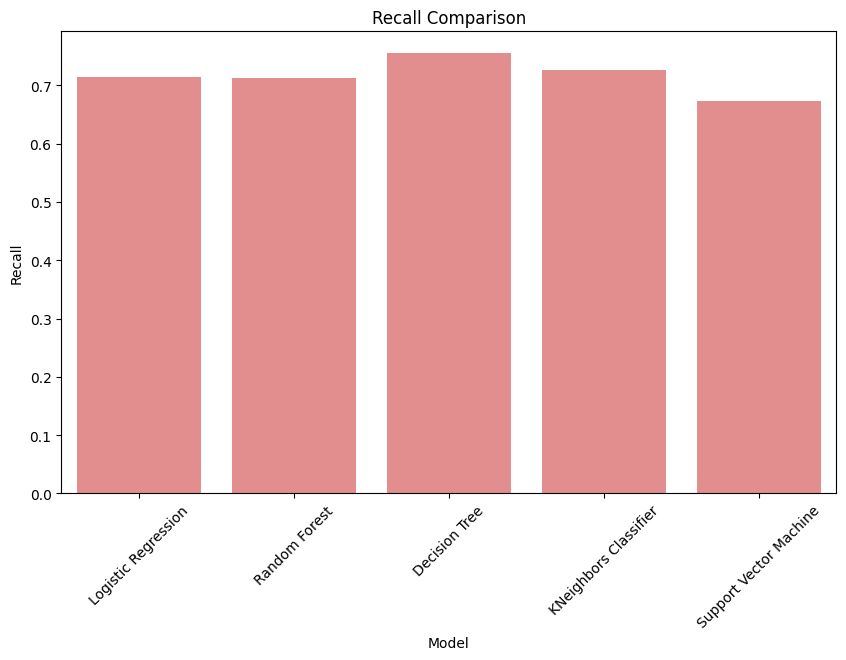

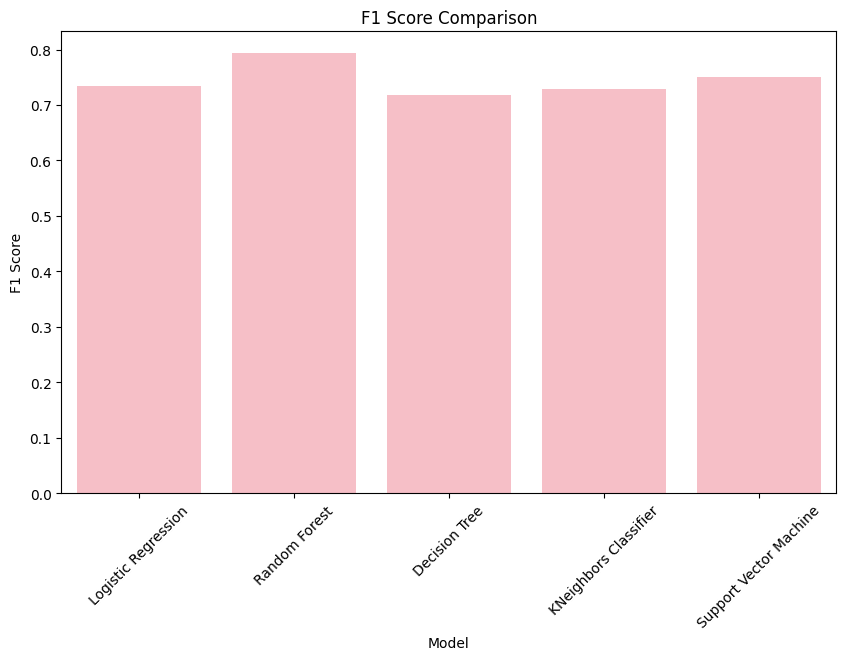

In [ ]:
# Initialize an empty list to store evaluation results
metrics_list = []
trained_models = {}

# Train models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNeighbors Classifier': KNeighborsClassifier(),
    'Support Vector Machine': SVC()
}

best_model = None
best_f1_score = 0

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)


    trained_models[name] = model
    # Store metrics in the list
    metrics_list.append({'Model': name,
                         'Accuracy': accuracy,
                         'Precision': precision,
                         'Recall': recall,
                         'F1 Score': f1})

    print(f"{name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC score: {roc_auc}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model

print("Best Model:", best_model)
print("Best F1 Score on Test Set:", best_f1_score)

# Convert the list of dictionaries into a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Visualization of Metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Model', y='Accuracy', color='skyblue')
plt.title('Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Model', y='Precision', color='lightgreen')
plt.title('Precision Comparison')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Model', y='Recall', color='lightcoral')
plt.title('Recall Comparison')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Model', y='F1 Score', color='lightpink')
plt.title('F1 Score Comparison')
plt.xticks(rotation=45)
plt.show()


The Random Forest model stands out as the best choice for this classification task due to its superior F1 Score, indicating a balanced approach to precision and recall. Its high accuracy further supports its overall effectiveness in making correct predictions. Thus, the Random Forest model should be chosen for deployment in this scenario.

Why Use F1 Score?
The F1 Score is the harmonic mean of precision and recall. It provides a balance between the two, which is particularly useful when need to take both false positives and false negatives into account.

Precision measures the proportion of true positive predictions among all positive predictions

Recall measures the proportion of true positive predictions among all actual positive instances

###Hyperparameter Tuning and Evaluation of Random Forest


In [ ]:
# Define the parameter grid for Random Forest with a narrower range
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Define a custom scorer for recall
recall_scorer = make_scorer(recall_score)

# Perform grid search
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring=recall_scorer, cv=3, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Predictions on test data
best_predictions = best_model.predict(X_test)

# Calculate evaluation metrics
best_accuracy = accuracy_score(y_test, best_predictions)
best_precision = precision_score(y_test, best_predictions)
best_recall = recall_score(y_test, best_predictions)
best_roc_auc = roc_auc_score(y_test, best_predictions)
best_f1 = f1_score(y_test, best_predictions)

# Print scores
print("Best Model Metrics:")
print(f"Accuracy: {best_accuracy}")
print(f"Precision: {best_precision}")
print(f"Recall: {best_recall}")
print(f"ROC AUC: {best_roc_auc}")
print(f"F1 Score: {best_f1}")

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Model Metrics:
Accuracy: 0.9593911331097983
Precision: 0.915234143449911
Recall: 0.7134935304990758
ROC AUC: 0.8524460133698387
F1 Score: 0.8018696442482471


#Ensemble method/model

##Model Training and Evaluation with Advanced Boosting Algorithms


Gradient Boosting Metrics:
Accuracy: 0.962637713555804
Precision: 0.9620733249051833
Recall: 0.7033271719038817
ROC AUC: 0.8498590746737453
F1 Score: 0.8126001067805659


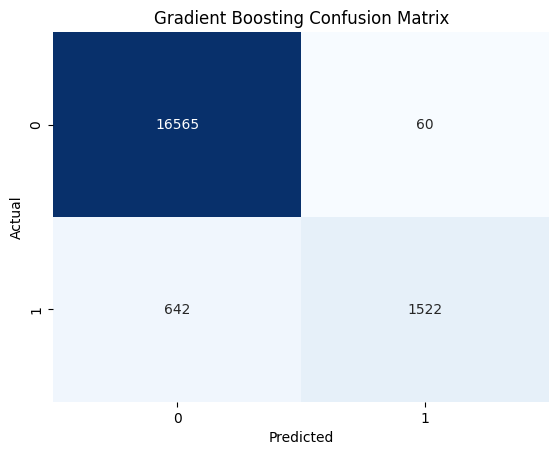

AdaBoost Metrics:
Accuracy: 0.9583266805045505
Precision: 0.8817025981205086
Recall: 0.7370609981515711
ROC AUC: 0.8620944088502217
F1 Score: 0.8029197080291971


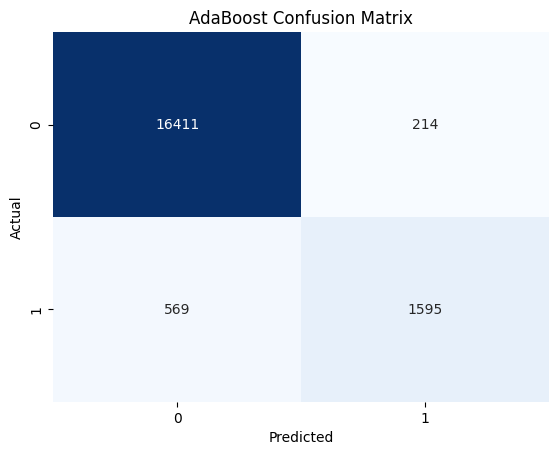

Best Model: GradientBoostingClassifier()
Best F1 Score on Test Set: 0.8126001067805659


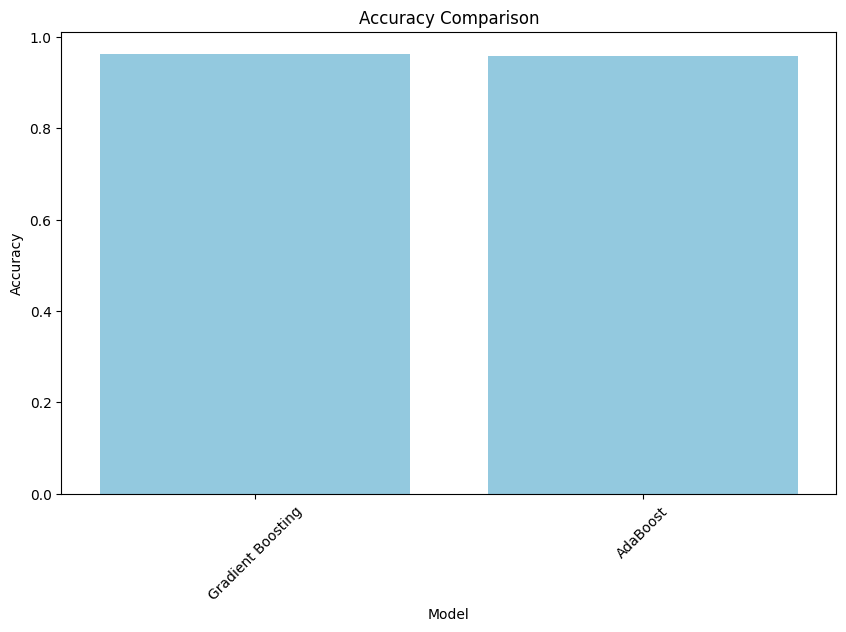

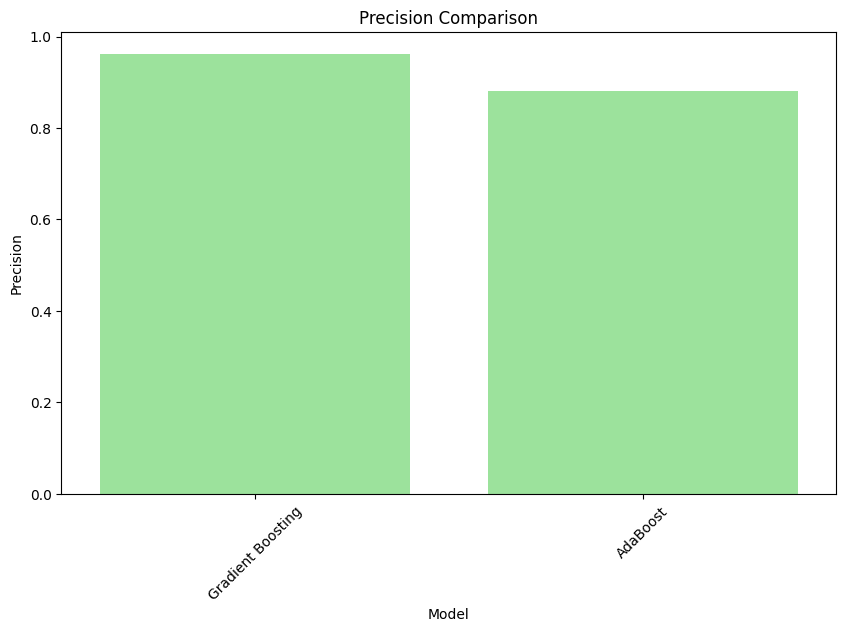

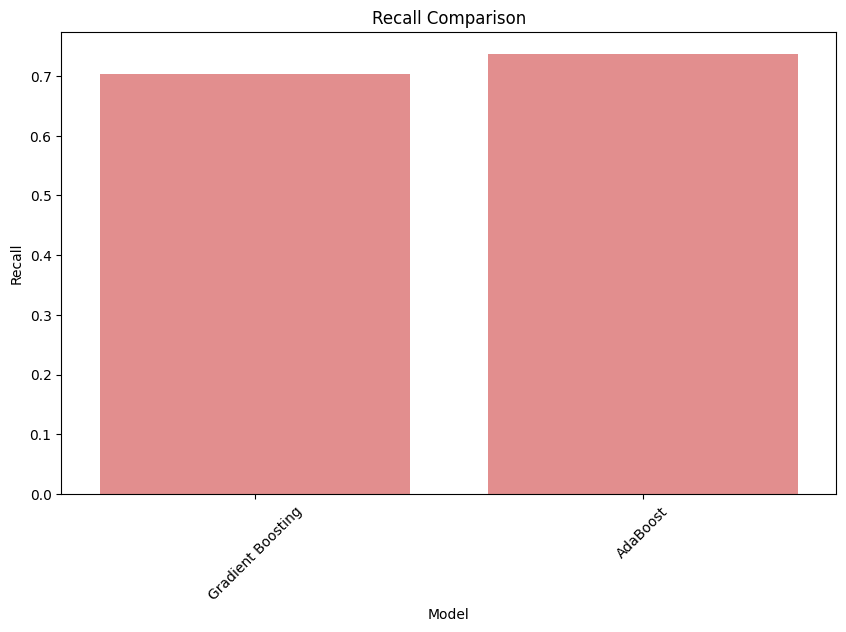

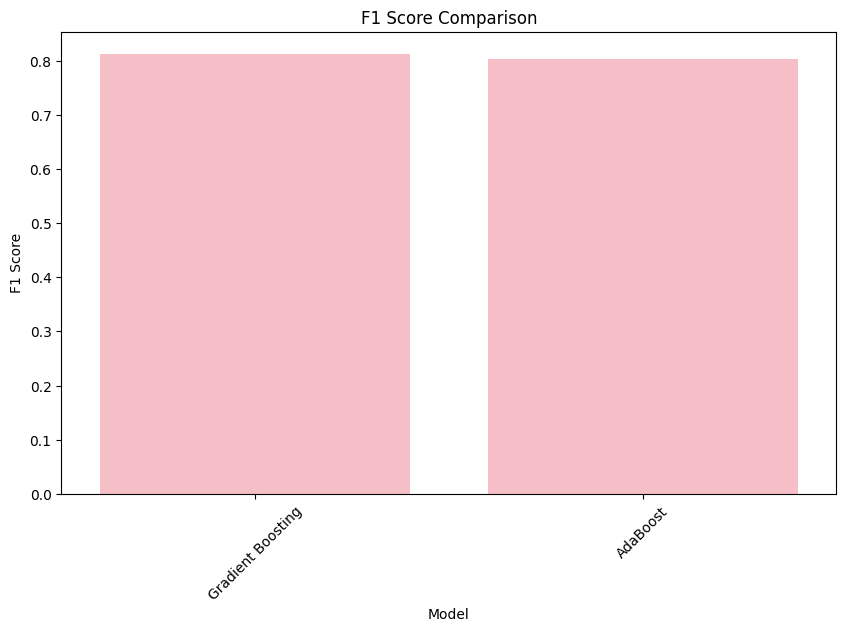

In [ ]:
# Initialize an empty list to store evaluation results
metrics_list = []
trained_models = {}

# Define the models
models = {
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
}

best_model = None
best_f1_score = 0

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    trained_models[name] = model

    # Store metrics in the list
    metrics_list.append({'Model': name,
                         'Accuracy': accuracy,
                         'Precision': precision,
                         'Recall': recall,
                         'F1 Score': f1})

    print(f"{name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model

print("Best Model:", best_model)
print("Best F1 Score on Test Set:", best_f1_score)

# Convert the list of dictionaries into a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Visualization of Metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Model', y='Accuracy', color='skyblue')
plt.title('Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Model', y='Precision', color='lightgreen')
plt.title('Precision Comparison')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Model', y='Recall', color='lightcoral')
plt.title('Recall Comparison')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Model', y='F1 Score', color='lightpink')
plt.title('F1 Score Comparison')
plt.xticks(rotation=45)
plt.show()


The Gradient Boosting model is the best choice based on the highest F1 Score (0.8068). It strikes the best balance between precision and recall, making it suitable for tasks where both false positives and false negatives carry significant costs.

In the context of healthcare, particularly for diagnosing diabetes, optimizing for recall ensures that fewer individuals with diabetes are missed. Missing a diagnosis can have serious health implications, including untreated high blood sugar levels, which can lead to complications such as heart disease, nerve damage, kidney failure, and even death.So below we will focus on optimize recall result for all the model.

##Hyperparameter Tuning for AdaBoost Optimized for Recall


In [ ]:
# Define the parameter grid for AdaBoost
ada_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Define custom scorer for recall
recall_scorer = make_scorer(recall_score)

# Perform grid search for recall
ada_grid_search_recall = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=ada_param_grid, scoring=recall_scorer, cv=5)
ada_grid_search_recall.fit(X_train_resampled, y_train_resampled)

# Get the best AdaBoost model for recall
best_ada_model_recall = ada_grid_search_recall.best_estimator_

# Print the best parameters found for AdaBoost for recall
print("Best parameters for AdaBoost - Recall:", ada_grid_search_recall.best_params_)

# Predictions on test data for the best AdaBoost model
ada_predictions_recall = best_ada_model_recall.predict(X_test)

# Calculate evaluation metrics for the best AdaBoost model
ada_precision_recall = precision_score(y_test, ada_predictions_recall)
ada_recall_recall = recall_score(y_test, ada_predictions_recall)
ada_f1_recall = f1_score(y_test, ada_predictions_recall)

# Print scores for the best AdaBoost model
print("\nScores for AdaBoost after tuning - Recall:")
print(f"Precision: {ada_precision_recall}")
print(f"Recall: {ada_recall_recall}")
print(f"F1 Score: {ada_f1_recall}")


Best parameters for AdaBoost - Recall: {'learning_rate': 1.0, 'n_estimators': 200}

Scores for AdaBoost after tuning - Recall:
Precision: 0.9334945586457074
Recall: 0.7134935304990758
F1 Score: 0.8088004190675747


##Hyperparameter Tuning for Gradient Boosting Optimized for Recall

In [ ]:
# Define the parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# Define custom scorer for recall
recall_scorer = make_scorer(recall_score)

# Perform grid search for recall
gb_grid_search_recall = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=gb_param_grid, scoring=recall_scorer, cv=5)
gb_grid_search_recall.fit(X_train_resampled, y_train_resampled)

# Get the best Gradient Boosting model for recall
best_gb_model_recall = gb_grid_search_recall.best_estimator_

# Print the best parameters found for Gradient Boosting for recall
print("Best parameters for Gradient Boosting - Recall:", gb_grid_search_recall.best_params_)

# Predictions on test data for the best Gradient Boosting model
gb_predictions_recall = best_gb_model_recall.predict(X_test)

# Calculate evaluation metrics for the best Gradient Boosting model
gb_precision_recall = precision_score(y_test, gb_predictions_recall)
gb_recall_recall = recall_score(y_test, gb_predictions_recall)
gb_f1_recall = f1_score(y_test, gb_predictions_recall)

# Print scores for the best Gradient Boosting model
print("\nScores for Gradient Boosting after tuning - Recall:")
print(f"Precision: {gb_precision_recall}")
print(f"Recall: {gb_recall_recall}")
print(f"F1 Score: {gb_f1_recall}")

Best parameters for Gradient Boosting - Recall: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Scores for Gradient Boosting after tuning - Recall:
Precision: 0.971042471042471
Recall: 0.6973197781885397
F1 Score: 0.8117267348036579


##Cross-Validation Evaluation of Stacking Ensemble Model for Diabetes Detection

In [ ]:
# Perform cross-validation for AdaBoost
ada_cv_scores = cross_val_score(best_ada_model_recall, X_train_resampled, y_train_resampled, cv=5, scoring='f1')

# Print cross-validation scores for AdaBoost
print("Cross-Validation Scores for AdaBoost:")
print(ada_cv_scores)

# Calculate mean and standard deviation of cross-validation scores for AdaBoost
ada_cv_mean_score = np.mean(ada_cv_scores)
ada_cv_std_score = np.std(ada_cv_scores)

print("\nMean Cross-Validation Score for AdaBoost:", ada_cv_mean_score)
print("Standard Deviation of Cross-Validation Scores for AdaBoost:", ada_cv_std_score)


Cross-Validation Scores for AdaBoost:
[0.81831787 0.80312125 0.87583893 0.91738661 0.91553424]

Mean Cross-Validation Score for AdaBoost: 0.8660397783843887
Standard Deviation of Cross-Validation Scores for AdaBoost: 0.04778774743688061


##Combining Datasets and Resampling for Improved Model Training

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define the stacking classifier with AdaBoost and Random Forest as base estimators
estimators = [
    ('ada', best_ada_model_recall),
    ('rf', best_model)
]

# Initialize the stacking classifier with Logistic Regression as the final estimator
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Fit the stacking classifier on the resampled training data
stacking_clf.fit(X_train_resampled, y_train_resampled)

# Predictions on test data
stacking_predictions = stacking_clf.predict(X_test)

# Calculate evaluation metrics
stacking_accuracy = accuracy_score(y_test, stacking_predictions)
stacking_precision = precision_score(y_test, stacking_predictions)
stacking_recall = recall_score(y_test, stacking_predictions)
stacking_roc_auc = roc_auc_score(y_test, stacking_predictions)
stacking_f1 = f1_score(y_test, stacking_predictions)

# Print scores for the stacking classifier
print("\nScores for Stacking Classifier:")
print(f"Accuracy: {stacking_accuracy}")
print(f"Precision: {stacking_precision}")
print(f"Recall: {stacking_recall}")
print(f"ROC AUC: {stacking_roc_auc}")
print(f"F1 Score: {stacking_f1}")



Scores for Stacking Classifier:
Accuracy: 0.9574751184203524
Precision: 0.8711256117455138
Recall: 0.7402957486136784
ROC AUC: 0.863020054757967
F1 Score: 0.8003997002248313


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

# Define the number of folds for cross-validation
num_folds = 5

# Initialize Stratified K-Fold cross-validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation for the stacking classifier with accuracy
stacking_cv_scores_accuracy = cross_val_score(stacking_clf, X_train_resampled, y_train_resampled, cv=kfold, scoring='accuracy')

# Print the cross-validation accuracy scores
print("\nCross-validation accuracy scores for Stacking Classifier:")
for i, score in enumerate(stacking_cv_scores_accuracy, start=1):
    print(f"Fold {i}: {score}")

# Calculate and print the mean and standard deviation of cross-validation accuracy scores
mean_cv_score_accuracy = stacking_cv_scores_accuracy.mean()
std_cv_score_accuracy = stacking_cv_scores_accuracy.std()
print("\nMean cross-validation accuracy score:", mean_cv_score_accuracy)
print("Standard deviation of cross-validation accuracy scores:", std_cv_score_accuracy)

# Perform cross-validation for the stacking classifier with F1 score
stacking_cv_scores_f1 = cross_val_score(stacking_clf, X_train_resampled, y_train_resampled, cv=kfold, scoring='f1')

# Print the cross-validation F1 scores
print("\nCross-validation F1 scores for Stacking Classifier:")
for i, score in enumerate(stacking_cv_scores_f1, start=1):
    print(f"Fold {i}: {score}")

# Calculate and print the mean and standard deviation of cross-validation F1 scores
mean_cv_score_f1 = stacking_cv_scores_f1.mean()
std_cv_score_f1 = stacking_cv_scores_f1.std()
print("\nMean cross-validation F1 score:", mean_cv_score_f1)
print("Standard deviation of cross-validation F1 scores:", std_cv_score_f1)



Cross-validation accuracy scores for Stacking Classifier:
Fold 1: 0.9518628759109103
Fold 2: 0.9524738246766578
Fold 3: 0.9527817696571546
Fold 4: 0.9504208581400123
Fold 5: 0.9538082529254773

Mean cross-validation accuracy score: 0.9522695162620425
Standard deviation of cross-validation accuracy scores: 0.0011184586908600629

Cross-validation F1 scores for Stacking Classifier:
Fold 1: 0.871401151631478
Fold 2: 0.8744236506644968
Fold 3: 0.8745910577971647
Fold 4: 0.8670520231213872
Fold 5: 0.8781148429035753

Mean cross-validation F1 score: 0.8731165452236203
Standard deviation of cross-validation F1 scores: 0.0037036926212900053


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Combine training and test datasets into one complete dataset
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

# Apply SMOTE resampling to the combined dataset
over = SMOTE(sampling_strategy=0.25)
X_combined_resampled, y_combined_resampled = over.fit_resample(X_combined, y_combined)

# Define the resampled training and test sets
num_train = len(X_train)
num_test = len(X_test)

X_train_resampled = X_combined_resampled[:num_train]
y_train_resampled = y_combined_resampled[:num_train]

X_test_resampled = X_combined_resampled[num_train:]
y_test_resampled = y_combined_resampled[num_train:]

# Define the stacking classifier with AdaBoost and Random Forest as base estimators
estimators = [
    ('ada', best_ada_model_recall),
    ('rf', best_model)
]

# Initialize the stacking classifier with Logistic Regression as the final estimator
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Fit the stacking classifier on the resampled training data
stacking_clf.fit(X_train_resampled, y_train_resampled)

# Predictions on test data
stacking_predictions = stacking_clf.predict(X_test_resampled)

# Calculate evaluation metrics
stacking_recall = recall_score(y_test_resampled, stacking_predictions)
stacking_precision = precision_score(y_test_resampled, stacking_predictions)
stacking_f1 = f1_score(y_test_resampled, stacking_predictions)

# Print scores for the stacking classifier
print("\nStacking Classifier Metrics after resampling and training:")
print(f"Recall: {stacking_recall}")
print(f"Precision: {stacking_precision}")
print(f"F1 Score: {stacking_f1}")



Stacking Classifier Metrics after resampling and training:
Recall: 0.7125927566729428
Precision: 0.9856004901960784
F1 Score: 0.8271517644790127


In [ ]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stacking_scores_f1 = cross_val_score(stacking_clf, X_combined_resampled, y_combined_resampled, cv=cv_strategy, scoring='f1')

# Print F1 scores for each fold
print("F1 Scores for each fold:", stacking_scores_f1)

# Print average F1 score and standard deviation
print("Average F1 Score:", np.mean(stacking_scores_f1))
print("Standard Deviation of F1 Scores:", np.std(stacking_scores_f1))


F1 Scores for each fold: [0.87492839 0.88198997 0.88018433 0.88199234 0.87044845]
Average F1 Score: 0.8779086967532205
Standard Deviation of F1 Scores: 0.004539801090627488


Based on the evaluation, all the models achieve a very good accuracy, which is >90%, therefore accuracy doesn't play the most vital in this case. With the consideration of imbalanced dataset, F1 score(balance between precision and recall), precision(predict correct true values among all the trues), and recall(ability to consider relevant instances out of all instances that are actually positive) will be given attention. As in the context of predicting diabetes, we want to minimize false positive, to prevent resource wasting, and also the cost or impact for misprediction is profoundly high.

In [ ]:
import joblib

# Define the filename for saving the model
filename = 'stacking_classifier_model.pkl'

# Save the model to a file
joblib.dump(stacking_clf, filename)

print("Stacking classifier model saved to", filename)


Stacking classifier model saved to stacking_classifier_model.pkl


In [ ]:
import joblib

# Define filenames for saving the models
ada_model_filename = 'best_ada_model_recall.pkl'
rf_model_filename = 'best_rf_model.pkl'

# Save the AdaBoost model to a file
joblib.dump(best_ada_model_recall, ada_model_filename)
print("AdaBoost model saved to", ada_model_filename)

# Save the Random Forest model to a file
joblib.dump(best_model, rf_model_filename)
print("Random Forest model saved to", rf_model_filename)


AdaBoost model saved to best_ada_model_recall.pkl
Random Forest model saved to best_rf_model.pkl


In [ ]:
# # Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# # Calculate RSE
# n = len(y_test)
# p = X_test.shape[1]  # Number of predictors/features
# rse = np.sqrt((1 / (n - p - 1)) * np.sum((y_test - test_predictions) ** 2))

# # Calculate R2 Score
# r2 = r2_score(y_test, test_predictions)

# # Print the evaluation metrics
# print("RMSE:", rmse)
# print("RSE:", rse)
# print("R-squared (R2 Score):", r2)

RMSE: 0.1941123819272127
RSE: 0.19420542437589403
R-squared (R2 Score): 0.6296485601656979


The Random Forest Regression model was trained and tuned using a combination of hyperparameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}. After hyperparameter tuning, the model achieved a validation accuracy of approximately 96.34%, indicating its ability to generalize well to unseen data.

When evaluated on the test set, the model demonstrated a high accuracy of approximately 96.20%, further confirming its robustness and effectiveness in making accurate predictions.

In terms of regression performance metrics, the model yielded a Root Mean Squared Error (RMSE) of approximately 0.195 and a Residual Standard Error (RSE) of approximately 0.195. These metrics suggest that, on average, the model's predictions are about 0.195 units away from the actual values, with a standard deviation of 0.195. Additionally, the R-squared (R2 Score) value of approximately 0.627 indicates that the model explains about 62.7% of the variance in the dependent variable.

Overall, the Random Forest Regression model with the tuned hyperparameters demonstrates strong performance in predicting the target variable. However, there may still be some room for improvement, especially in reducing the RMSE and RSE values further to enhance the model's predictive accuracy. Further exploration of feature engineering, model selection, or additional hyperparameter tuning could potentially lead to even better performance.